<a href="https://colab.research.google.com/github/charlottetse33/Data-science-portfolio/blob/main/Telco_Customer_Churn_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing data 
import pandas as pd
url_data = "https://raw.githubusercontent.com/charlottetse32/Telco-Customer-Churn-/main/WA_Fn-UseC_-Telco-Customer-Churn.csv"
data = pd.read_csv(url_data, index_col='customerID')

# Foundation

In [ ]:
!pip install git+https://github.com/MaxHalford/Prince

  Cloning https://github.com/MaxHalford/Prince to /tmp/pip-req-build-983kzfaq
  Running command git clone -q https://github.com/MaxHalford/Prince /tmp/pip-req-build-983kzfaq
  Created wheel for prince: filename=prince-0.7.0-cp37-none-any.whl size=21609 sha256=c7f8810f27b3be5cbdc56afeec4111eafd8f19d5b2c975523dff2b2cd05a7a9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-rs2mu299/wheels/59/35/55/c6f9d6f898d74a07502ce2a3997c8c8ddc04dd54ba2391fc27
Successfully built prince


In [ ]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
# split train and test data
from sklearn.model_selection import train_test_split
# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# for normalization
from sklearn import preprocessing
# libraries for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import prince

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Global Functions 
def cat_to_num_df(num_col, cat_col, df):
  col_list = df[cat_col].unique()
  df = pd.DataFrame({})
  for col in col_list:
    df[col] = []
  return df

def p_test(num_list, df):
  comparison_df = pd.DataFrame({'Numerical Variable 1': [], 'Numerical Variable 2': [], 'R': [], 'P-value': []})
  for i in range(len(num_list)):
    for j in range(i+1, len(num_list)):
      try:
        r, p_value = stats.pearsonr(df[num_list[i]], df[num_list[j]])
        new_row = {'Numerical Variable 1': num_list[i], 'Numerical Variable 2': num_list[j], 'R': r, 'P-value': p_value}
        comparison_df = comparison_df.append(new_row, ignore_index=True)
      except:
        print(num_list[i], num_list[j])
  return comparison_df

def calc_vif(X):
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  return(vif)

def chi_square_test(cat_list, df):
  comparison_df = pd.DataFrame({'Categorical Variable 1': [], 'Categorical Variable 2': [], 'Test_statistic': [], 'P-value': [], 'DoF': []})
  for i in range(len(cat_list)):
    for j in range(i+1, len(cat_list)):
      try:
        table = pd.crosstab(df[cat_list[i]], df[cat_list[j]])
        test_statistic, pvalue, dof, _ = stats.chi2_contingency(table)
        new_row = {'Categorical Variable 1': cat_list[j], 'Categorical Variable 2': cat_list[i], \
                  'Test_statistic': test_statistic, 'P-value': pvalue, 'DoF': dof}
        comparison_df = comparison_df.append(new_row, ignore_index=True)
      except:
        print(cat_list[i], cat_list[j])
  return comparison_df
   

def point_biserial_correlation_test(indep_var_cat_list, indep_var_num_list, df):
  comparison_df = pd.DataFrame({'Categorical Variable': [], 'Numerical Variable': [], 'Correlation': [], 'P-value': []})
  for cat in indep_var_cat_list:
    for num in indep_var_num_list:
      cat_var = cat
      num_var = num
      try:
        correlation, p_value = stats.pointbiserialr(df[cat], df[num])
        new_row = {'Categorical Variable': cat_var, 'Numerical Variable': num_var, 'Correlation': correlation, 'P-value': p_value }
        comparison_df = comparison_df.append(new_row, ignore_index=True)
      except:
        print(cat, num)
  return comparison_df

def one_way_anova_test(num_list, cat_list, df):
  comparison_df = pd.DataFrame({'Numerical Variable': [], 'Categorical Variable': [], 'F': [], 'P-value': []})
  for num in num_list:
    for cat in cat_list:
      try:
        unqiue_values = set(df[cat])
        to_collapse_nested_list = []
        for unquie_attribute in unqiue_values:
          to_collapse_nested_list.append((df[df[cat] == unquie_attribute][num]).tolist())
        f, p_value = stats.f_oneway(*to_collapse_nested_list)
        new_row = {'Numerical Variable': num, 'Categorical Variable': cat, 'F': f, 'P-value': p_value}
        comparison_df = comparison_df.append(new_row, ignore_index=True)
      except:
        print(num, cat)
  return comparison_df

def two_way_anova_test(num_list, cat_list, df):
  comparison_df = pd.DataFrame({'Indep_num_var':[], 'Indep_cat_var':[], 'Churn_F':[], 'Churn_p_val':[], \
                  'Cat_var_F':[], 'Cat_var_p_val':[], 'Interaction_F':[], 'Interaction_p_val':[]})
  for num in num_list:
    for cat in cat_list:
      formula = num + ' ~ C(Churn) + C(' + cat + ') + C(Churn):C(' + cat + ')'
      try:
        model = ols(formula, data=df).fit()
        temp_df = sm.stats.anova_lm(model, typ=2)
        new_row = {'Indep_num_var':num,'Indep_cat_var':cat, 'Churn_F':temp_df.iloc[0,2], 'Churn_p_val':temp_df.iloc[0,3], \
              'Cat_var_F':temp_df.iloc[1,2], 'Cat_var_p_val':temp_df.iloc[1,3], \
              'Interaction_F':temp_df.iloc[2,2], 'Interaction_p_val':temp_df.iloc[2,3]}
        comparison_df = comparison_df.append(new_row,ignore_index=True)
      except:
        print(num, cat)
  return comparison_df

def add_Interactive_variable(combinations_df, df, dfDrop):
  for i in range(len(combinations_df)):
    num_var = combinations_df['Numerical Variable'][i]
    cat_var = combinations_df['Categorical Variable'][i]
    temp_onehot_df = pd.get_dummies(X[cat_var],prefix = cat_var)
    for j in range(len(temp_onehot_df)):
      for k in range(len(temp_onehot_df.columns)):
        if (temp_onehot_df.iloc[j,k] == 1):
          temp_onehot_df.iloc[j,k] = df[num_var][j]
    temp_onehot_df = temp_onehot_df.iloc[:, :-1]
    for original_col_name in temp_onehot_df.columns:
      temp_onehot_df = temp_onehot_df.rename(columns={original_col_name: original_col_name + '_' + num_var})
    dfDrop[temp_onehot_df.columns] = temp_onehot_df
  return dfDrop

def group_same_type_row(df):
  tuple_list = []
  cat_col = []
  num_col = []
  for i in range(len(df)):
    temp_tuple = (df['Categorical Variable'][i].split('_', 1)[0],df['Numerical Variable'][i])
    tuple_list.append(temp_tuple)
  tuple_list = list(set(tuple_list))
  for j in range(len(tuple_list)):
    cat_col.append(tuple_list[j][0])
    num_col.append(tuple_list[j][1])    
  return pd.DataFrame({'Categorical Variable':cat_col, 'Numerical Variable': num_col})

def oneHotEncoding(df, cat_list):
  _df = df.copy(deep=True)
  for cat in cat_list:
    temp_df = pd.get_dummies(_df[cat],prefix = cat)
    if cat == 'SeniorCitizen':
      temp_df = temp_df.drop(columns=['SeniorCitizen_1'])
    elif cat == 'Contract':
      temp_df = temp_df.drop(columns=['Contract_Two year'])
    else:
      temp_df = temp_df.iloc[:,:-1]
    _df = _df.drop(columns=[cat])
    _df[temp_df.columns] = temp_df
    try:
      _df = _df.rename(columns={'SeniorCitizen_0': 'SeniorCitizen'})
    except:
      print("Failed to rename Senior Citizen")
  return _df
    

    


# Data Understanding

In [ ]:
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
# convert to float datatype
data.loc[:, 'TotalCharges'] = pd.to_numeric(data.loc[:, 'TotalCharges'], errors='coerce')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1513097e10>,
      dtype=object)

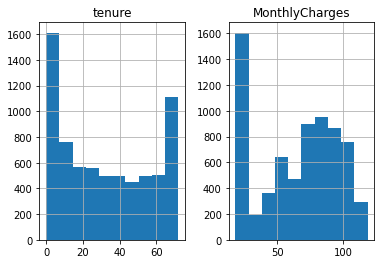

In [ ]:
data[['tenure', 'MonthlyCharges']].hist()

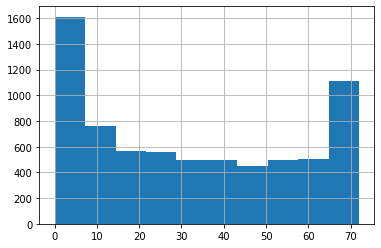

In [ ]:
data['tenure'].hist()

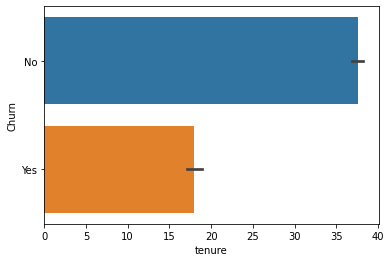

In [ ]:
sns.barplot(x = data['tenure'], y = data['Churn'])

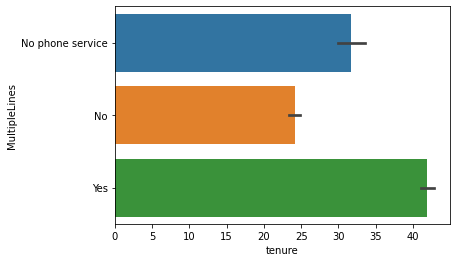

In [ ]:
sns.barplot(x = data['tenure'], y = data['MultipleLines'])

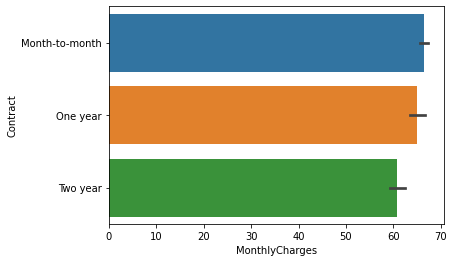

In [ ]:
sns.barplot(x = data['MonthlyCharges'], y = data['Contract'])

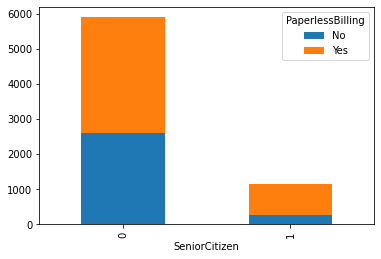

In [ ]:
pd.crosstab(data['SeniorCitizen'], data['PaperlessBilling']).plot.bar(stacked=True)

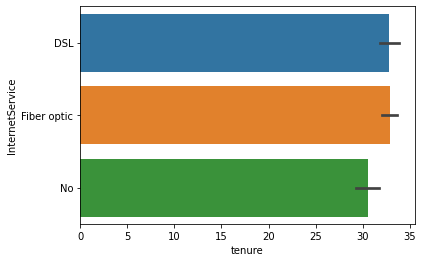

In [ ]:
sns.barplot(x = data['tenure'], y = data['InternetService'])

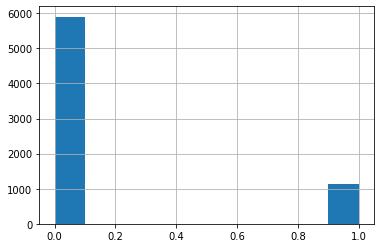

In [ ]:
data['SeniorCitizen'].hist()

In [ ]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


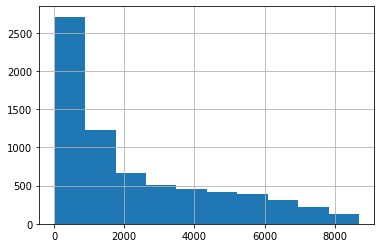

In [ ]:
data['TotalCharges'].hist()

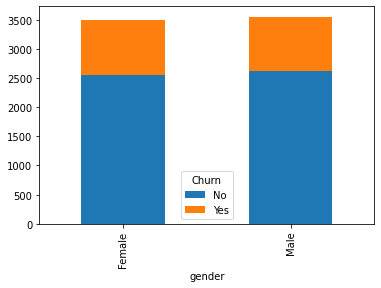

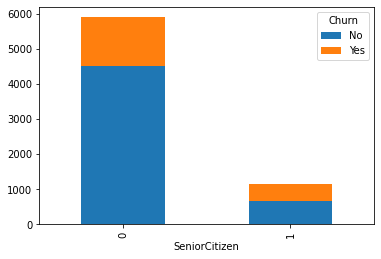

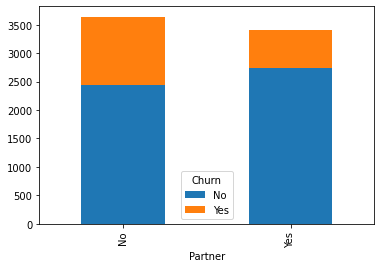

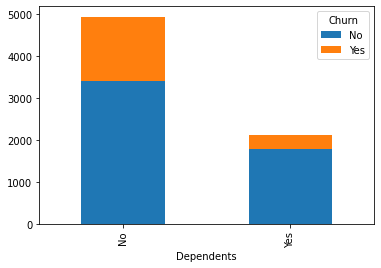

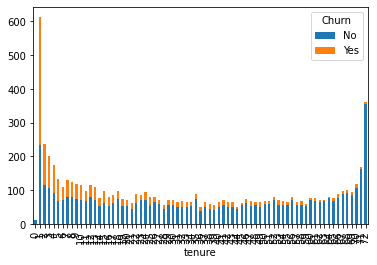

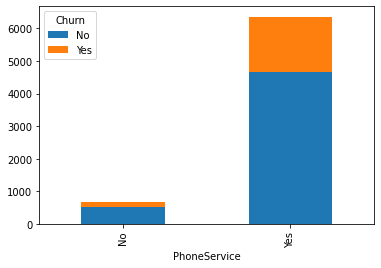

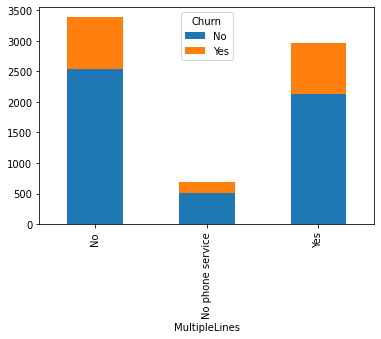

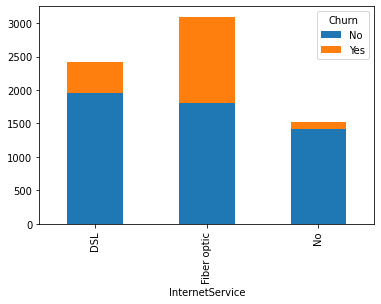

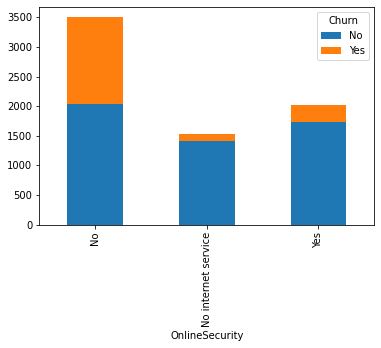

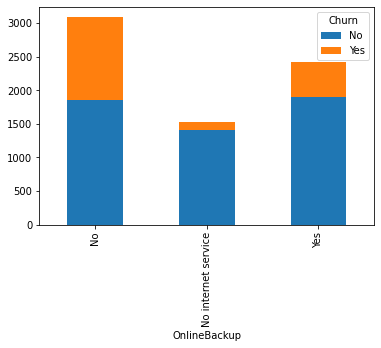

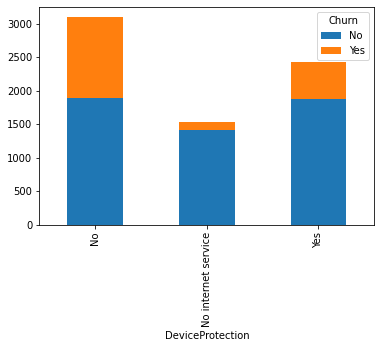

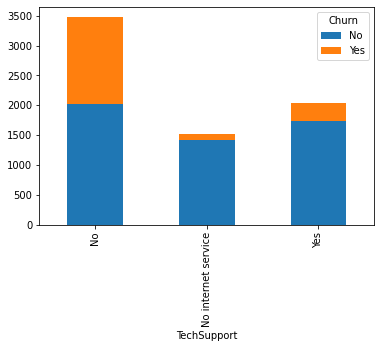

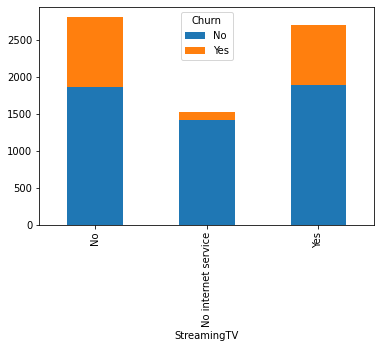

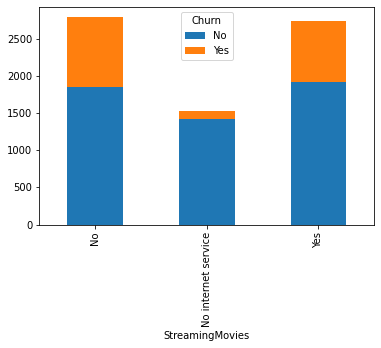

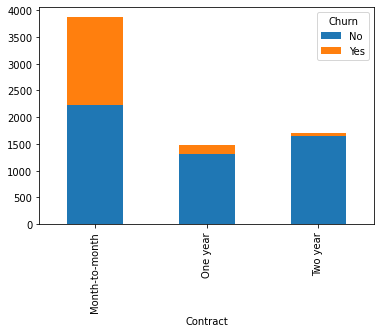

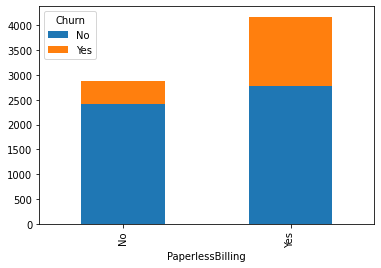

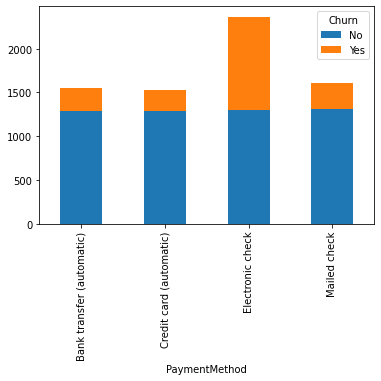

In [ ]:
pd.crosstab(data['gender'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['SeniorCitizen'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['Partner'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['Dependents'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['tenure'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['PhoneService'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['MultipleLines'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['InternetService'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['OnlineSecurity'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['OnlineBackup'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['DeviceProtection'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['TechSupport'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['StreamingTV'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['StreamingMovies'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['Contract'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['PaperlessBilling'], data['Churn']).plot.bar(stacked=True)
pd.crosstab(data['PaymentMethod'], data['Churn']).plot.bar(stacked=True)

## Data Cleaning

In [ ]:
#For label encoding
from sklearn import preprocessing

In [ ]:
features = list(data.columns)
features.remove('Churn')
target = ['Churn']
X = data[features]
y = data[target]

In [ ]:
# convert yes, no to 1, 0
y.loc[:,'Churn'] = y.loc[:,'Churn'].map({'Yes': 1, 'No': 0})
# replace missing value in "TotalCharges" with mean
X['TotalCharges'].fillna(X['TotalCharges'].mean(),inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
# Apply min-max normalization on MonthlyCharges & TotalCharges
minmax_scaler = preprocessing.MinMaxScaler().fit(X[['MonthlyCharges']])
minmax_scaler = preprocessing.MinMaxScaler().fit(X[['TotalCharges']])

X['MonthlyCharges_minmax']=minmax_scaler.transform(X[['MonthlyCharges']])
X['TotalCharges_minmax']=minmax_scaler.transform(X[['TotalCharges']])

In [ ]:
X.pop("MonthlyCharges")
X.pop("TotalCharges")

customerID
7590-VHVEG      29.85
5575-GNVDE    1889.50
3668-QPYBK     108.15
7795-CFOCW    1840.75
9237-HQITU     151.65
               ...   
6840-RESVB    1990.50
2234-XADUH    7362.90
4801-JZAZL     346.45
8361-LTMKD     306.60
3186-AJIEK    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

# Create dataset with label encoding (Xencode)

For categorical variables in the data, a lot of them are not label encoded. Therefore, we performed
label encoding on the variables first to perform preliminary analysis for convenience purpose. \

In Point-biserial correlation onwards, we used dummy variables instead. Since point-biserial
correlation requires one variable to be dichotomous (mutually exclusive), we added dummy variables
for each categorical variable. In general, regression requires (c-1) dummy variables to distinguish the
observations associated with c categories. If there are dummy variables, columns in the matrix would
be linearly dependent,for either least square or maximum likelihood, there will be multiple solutions
to the matrix. Thus, we cannot use c dummy variables. \

Dummy variable is used in logistic regression instead of label encoding because label encoding
implies the categorical independent variables are ordinal. In fact, most categorical variables are not
ordered. Hence, dummy variables are used.

In [ ]:
label_encoder = preprocessing.LabelEncoder()
indep_var_cat_list = ['SeniorCitizen', 'gender','Partner','Dependents','PhoneService','MultipleLines','InternetService',\
            'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',\
            'Contract','PaperlessBilling','PaymentMethod']

In [ ]:
Xencode = X.copy(deep=True)
for col in indep_var_cat_list:
  Xencode[col]= label_encoder.fit_transform(Xencode[col])

In [ ]:
#Later use of data creation
XbeforeDrop = X.copy(deep=True)
XnoDrop = X.copy(deep=True)

# Correlation Tests

One assumption of Logistics regression is that there is no dependency among independent variables.
Even if this is violated, but we do not need to interpret the coefficients, we could live with the
multicollinearity problem from the data. The reason why the effect of multicollinearity would be
detrimental for our project is as follows: \

When we fit an independent variable with logistics regression, the coefficient of the independent
variable is called a marginal regression coefficient. When we fit multiple independent variables, the
coefficient of independent variables are called partial regression coefficients. When there is a
multicollinearity problem, the marginal coefficient might be negative, while the partial coefficient
might be positive. Such effects come from proxy effects, which captures the interaction between
independent variables. Variables that exhibit such behavior would be called a confounding variable.
Marginal effect = Partial effect + Proxy effect. In this case, the proxy effect is negative, thus the
marginal effect is negative. \

We would like to get some accurate business insights from the coefficients of logistics regression, thus
we would perform the following tests to solve the multicollinearity problem.

In [ ]:
import scipy.stats as stats
indep_var_cat_list = ['SeniorCitizen', 'gender','Partner','Dependents','PhoneService','MultipleLines','InternetService',\
            'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',\
            'Contract','PaperlessBilling','PaymentMethod']
'''
indep_var_cat_list = ['SeniorCitizen', 'gender_Male','Partner_Yes','Dependents_Yes','PhoneService_Yes','MultipleLines_No',\
                      'MultipleLines_Yes','InternetService_DSL','InternetService_Fiber optic',\
                      'OnlineSecurity_No','OnlineSecurity_Yes','OnlineBackup_No','OnlineBackup_Yes',\
                      'DeviceProtection_No','DeviceProtection_Yes','TechSupport_No','TechSupport_Yes',\
                      'StreamingTV_No','StreamingTV_Yes','StreamingMovies_No','StreamingMovies_Yes',\
                      'Contract_Month-to-month','Contract_Two year','PaperlessBilling_Yes',\
                      'PaymentMethod_Bank transfer (automatic)','PaymentMethod_Electronic check','PaymentMethod_Mailed check']
'''
indep_var_num_list = ['MonthlyCharges_minmax', 'TotalCharges_minmax','tenure']
dep_var_cat_list = ['Churn']

# Pearson Correlation Test (num + num)(on all columns)

Pearson correlation coefficient measures the linear correlation between two numerical variables. One
concern is that the numerical variables might not be linear, thus we also used Variable Inflation factor
as a backup test. Furthermore, we only have 3 numerical independent variables in the dataset, it would
not be necessary to do a Spearman’s rank correlation coefficient test, which assesses the correlation
using a monotonic function.

In [ ]:
#Pearson Correlation Test
nn_comparison_df = p_test(indep_var_num_list, X).sort_values(by ='R', ascending=False)\
  .reset_index(drop=True)

In [ ]:
#there is relationship, > 0.05
display(nn_comparison_df)

,Numerical Variable 1,Numerical Variable 2,R,P-value
0,TotalCharges_minmax,tenure,0.824757,0.000000e+00
1,MonthlyCharges_minmax,TotalCharges_minmax,0.650468,0.000000e+00
2,MonthlyCharges_minmax,tenure,0.247900,4.094045e-99


It can be seen from the result that the p-value of these 3 combinations are below 0.05, it indicates
there is dependency among all 2 variables. \

We have to decide whether we should drop TotalCharges_minmax or tenure. Thus, we proceed to do
Variable Inflation factor to decide which variable we should drop.

# Variance inflation factor test

Variable Inflation factor (VIF) quantifies the severity of multicollinearity through coefficient of
determination (R-squared). It can only be applied to numerical variables. Generally, VIF below 5 is a
good indication that the problem of multicollinearity does not exist.

In [ ]:
#test on all numerical variables (including the dropped one)
vif = calc_vif(X[indep_var_num_list])
display(vif)

,variables,VIF
0,MonthlyCharges_minmax,3.509203
1,TotalCharges_minmax,9.562677
2,tenure,6.276250


From the above, TotalCharges_minmax and tenure both have VIF above 5, but we won’t drop both at
the same since dropping one will usually subsequently decrease the VIF for the rest. Since
TotalCharges_minmax has the largest VIF, we decided to drop TotalCharges_minmax.

#Drop Column (base on results from Pearson correlation test; create XbeforeDrop)

In [ ]:
#The drop is due to the Pearson correlation test
XbeforeDrop = X.copy(deep=True)

X = X.drop("TotalCharges_minmax", axis=1)
Xencode = Xencode.drop("TotalCharges_minmax", axis=1)
try:
  indep_var_num_list.remove("TotalCharges_minmax")
except:
  print("removed already")

# MCA

Multiple correspondence analysis (MCA) is a method that detects and represents underlying
associations between categorical variables that are related to Euclidean classification. \

MCA is similar to Principal component analysis (PCA), a widely used technique for dimensionality
reduction in data. Similar to PCA, MCA is also a method of dimension reduction. PCA are generally
performed in continuous variables, it is possible to use PCA on categorical variables, however, MCA
would be more suitable. Furthermore, MCA could transform categorical data into numerical data. 

PCA projects data to a 2 dimensional plane through a change of basis involving eigenvectors (linear
transformation in matrix operations) and covariance matrix. The calculation of covariance matrix
would be a problem for qualitative variables. Whereas, MCA uses a symmetric matrix of all two-way
cross-tabulations instead of a covariance matrix. \

In layman’s terms, covariance is a measure of joint variability of two numerical variables. If we
directly use covariance on categorical data, it would treat the categorical variables as numerical
variables and the result might not be accurate. While two-way cross-tabulation uses the frequency of
categorical variables, which is a more appropriate way for categorical variables.Thus, MCA is a more
suitable technique for categorical data. \

PCA was not employed for numerical variables because our data only have 3 numerical variables to
begin with, projecting a 3 dimensional data to 2 dimensions seems redundant.

In [ ]:
test = X[indep_var_cat_list]
test['Churn'] = pd.Series(y['Churn'])
test.reset_index(drop=True, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test.head()

,SeniorCitizen,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,0
1,0,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,0
2,0,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,1
3,0,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),0
4,0,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1


In [ ]:
mca = prince.MCA(
      n_components=2,
      n_iter=3,
      random_state=1)
mca = mca.fit(test)
mca_transformed = mca.fit_transform(test)

In [ ]:
print(mca_transformed)

             0         1
0    -0.560379 -0.106556
1    -0.175667 -0.030285
2    -0.303995 -0.351689
3    -0.392488  0.533862
4    -0.425068 -0.811613
...        ...       ...
7038 -0.259668  0.759626
7039 -0.341625  0.533536
7040 -0.517160  0.055478
7041 -0.391396 -0.565152
7042 -0.275751  0.495745

[7043 rows x 2 columns]


In [ ]:
mca.eigenvalues_

[0.5007073181733013, 0.1933870319351406]

In [ ]:
mca.total_inertia_

1.5294117647058822

In [ ]:
mca.explained_inertia_

[0.32738555419023546, 0.126445367034515]

Inertia of a component is the amount of variation the component explains, the components are ranked
according to inertia. Thus, the first dimension (component 0) in MCA is always more important than
the second dimension (component 1). With 2 components, it contributes 45.38% to the total inertia.

In [ ]:
mca.column_coordinates(test)

,0,1
SeniorCitizen,-0.485597,-0.317708
Churn,-0.442843,-0.725554
gender_Female,0.005209,0.026344
gender_Male,0.020810,0.006386
Partner_No,-0.012097,-0.450361
Partner_Yes,0.040034,0.515683
Dependents_No,-0.108186,-0.234915
Dependents_Yes,0.296601,0.603520
PhoneService_No,-0.631807,0.638934
PhoneService_Yes,0.082226,-0.050489


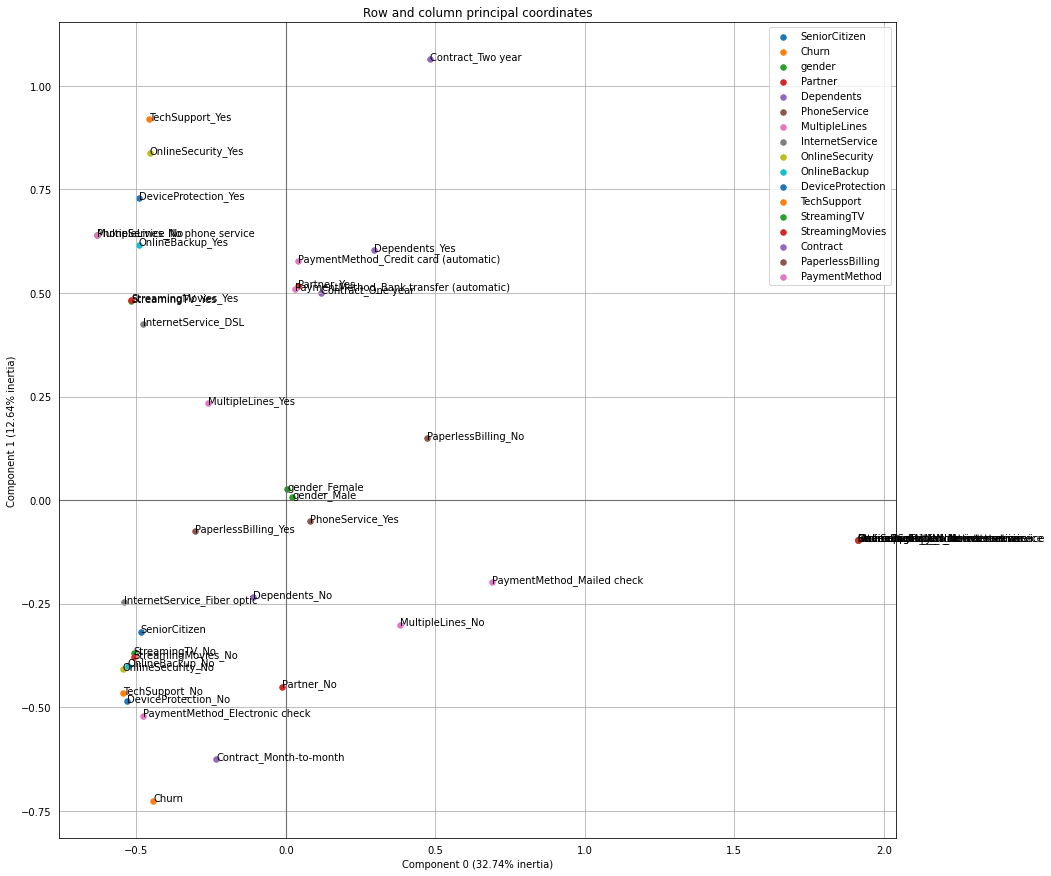

In [ ]:
ax = mca.plot_coordinates(
     X = test,
     ax=None,
     figsize=(15, 15),
     show_row_points=False,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=True,
     legend_n_cols=1)

One possible way to interpret it is that the closer the independent categorical variable is to the
dependent categorical variable (churn) implies a higher risk of churning. Since the first dimension is
always more important than the second dimension, and so on. \

Component 0 (x-axis) is more powerful than Component 1(y-axis). To illustrate this idea, let “a” be 1
unit away from the original point by horizontal distance, “b” be 1 unit away from the original point by
vertical distance, the association between “a” and the original point would be stronger than “b”. 

Those with month to month contractual agreements, and customers that do not pay for other services
by Telco are the most likely to churn.

# Chi-square Test of Independence (cat + cat)(not include to be dropped columns from Pearson test)

Since categorical variables have no such thing as “correlation test”, therefore we test dependency
among categorical variables. Chi-square test is a statistical hypothesis test, it’s a nonparametric test
that does not assume any underlying distribution (e.g. linearity). \

H0: Independent

HA: Dependent

0.05 is used as the critical value, if p-value < 0.05, we will reject the null hypothesis, thus the
variables are dependent. \

We also tested dependency among the independent variable (churn) and all the other dependent
variables. We found that all categories except PhoneService and gender have dependency on Churn.

In [ ]:
print(indep_var_cat_list)
print(X.columns)
print(len(indep_var_cat_list))
print(len(X.columns))

['SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges_minmax'],
      dtype='object')
16
18


In [ ]:
#Chi-Square Test of Independence
cc_comparison_df = chi_square_test(indep_var_cat_list + ['Churn'], X.assign(Churn = y['Churn']))

Since there are 16 categorical independent variables, meaning that there are 16C2 = 120 possible
pairs.
We drop the variables one by one and then run the regression again until no variables left have
dependency with each other. We drop variables by dropping one the variables of the pair which has
the highest F-statistics.

In [ ]:
dep_cc_comparison_df = cc_comparison_df[cc_comparison_df.apply(lambda x: x['Categorical Variable 1'] == 'Churn', axis=1)].sort_values(by ='Test_statistic', ascending=False)\
  .reset_index(drop=True)
indep_cc_comparison_df = cc_comparison_df[cc_comparison_df.apply(lambda x: x['Categorical Variable 1'] != 'Churn', axis=1)].sort_values(by ='Test_statistic', ascending=False)\
  .reset_index(drop=True)
try:
  dep_cc_comparison_df.pop("DoF")
  indep_cc_comparison_df.pop("DoF")
except:
  print("Dropped column already")

In [ ]:
dep_filtered_cc_comparison_df = dep_cc_comparison_df[dep_cc_comparison_df.apply(lambda x: (x['P-value']) > 0.05, axis=1)].sort_values(by ='Test_statistic', ascending=False)\
  .reset_index(drop=True)
indep_filtered_cc_comparison_df = indep_cc_comparison_df[indep_cc_comparison_df.apply(lambda x: (x['P-value']) < 0.05, axis=1)].sort_values(by ='Test_statistic', ascending=False)\
  .reset_index(drop=True)
dep_filtered_cc_comparison_df = dep_filtered_cc_comparison_df[dep_filtered_cc_comparison_df.apply(lambda x: (x['Test_statistic']) >= 000, axis=1)].sort_values(by ='Test_statistic', ascending=False)\
  .reset_index(drop=True)
indep_filtered_cc_comparison_df = indep_filtered_cc_comparison_df[indep_filtered_cc_comparison_df.apply(lambda x: (x['Test_statistic']) >= 1000, axis=1)].sort_values(by ='Test_statistic', ascending=False)\
  .reset_index(drop=True)
no_dep_indep_fileterd_cc_comparison_df = indep_cc_comparison_df[indep_cc_comparison_df.apply(lambda x: (x['P-value']) > 0.05, axis=1)].sort_values(by ='Test_statistic', ascending=False)\
  .reset_index(drop=True)

In [ ]:
#Filter data with p-value > 0.05 (find no relationship columns)
#Churn has no relationship with PhoneService_Yes and gender_Male
display(dep_filtered_cc_comparison_df)
#Filter data with p-value < 0.05 and test-statistic > 1000
display(indep_filtered_cc_comparison_df)
#Filter data with p-value > 0.05
display(no_dep_indep_fileterd_cc_comparison_df)

,Categorical Variable 1,Categorical Variable 2,Test_statistic,P-value
0,Churn,PhoneService,0.915033,0.338783
1,Churn,gender,0.484083,0.486579


,Categorical Variable 1,Categorical Variable 2,Test_statistic,P-value
0,StreamingMovies,StreamingTV,8374.206314,0.000000e+00
1,StreamingMovies,DeviceProtection,7631.314396,0.000000e+00
2,StreamingTV,DeviceProtection,7581.909452,0.000000e+00
3,TechSupport,OnlineSecurity,7569.722977,0.000000e+00
4,TechSupport,DeviceProtection,7434.321766,0.000000e+00
5,OnlineSecurity,InternetService,7393.058146,0.000000e+00
6,TechSupport,InternetService,7361.215210,0.000000e+00
7,TechSupport,OnlineBackup,7298.822720,0.000000e+00
8,DeviceProtection,OnlineBackup,7284.450039,0.000000e+00
9,OnlineBackup,OnlineSecurity,7270.460647,0.000000e+00


,Categorical Variable 1,Categorical Variable 2,Test_statistic,P-value
0,MultipleLines,Dependents,4.435045,0.108879
1,PaymentMethod,gender,2.448621,0.484648
2,PhoneService,Partner,2.089728,0.148292
3,OnlineSecurity,gender,2.041386,0.360345
4,Partner,SeniorCitizen,1.824079,0.176829
5,PaperlessBilling,PhoneService,1.806686,0.178906
6,PaperlessBilling,Partner,1.498722,0.220868
7,OnlineBackup,gender,1.340950,0.511466
8,PaperlessBilling,gender,0.925736,0.335973
9,InternetService,gender,0.902478,0.636839


# Chi-square test of Independence (on dropped columns)

In [ ]:
dropped_indep_var_cat_list = ['StreamingMovies','StreamingTV','TechSupport','OnlineSecurity','OnlineBackup',\
                'InternetService','PhoneService','Dependents','DeviceProtection','PaymentMethod']

In [ ]:
dropped_indep_cc_comparison_df = chi_square_test(dropped_indep_var_cat_list, X)

In [ ]:
display(dropped_indep_cc_comparison_df)

,Categorical Variable 1,Categorical Variable 2,Test_statistic,P-value,DoF
0,StreamingTV,StreamingMovies,8374.206314,0.000000e+00,4.0
1,TechSupport,StreamingMovies,7227.861930,0.000000e+00,4.0
2,OnlineSecurity,StreamingMovies,7064.962676,0.000000e+00,4.0
3,OnlineBackup,StreamingMovies,7174.586977,0.000000e+00,4.0
4,InternetService,StreamingMovies,7221.427329,0.000000e+00,4.0
5,PhoneService,StreamingMovies,221.949347,6.372528e-49,2.0
6,Dependents,StreamingMovies,140.688770,2.817226e-31,2.0
7,DeviceProtection,StreamingMovies,7631.314396,0.000000e+00,4.0
8,PaymentMethod,StreamingMovies,1062.611542,2.559348e-226,6.0
9,TechSupport,StreamingTV,7226.647348,0.000000e+00,4.0


# Chi-square test of Independence (not include to be dropped columns from Chi test)

In [ ]:
indep_var_cat_list = ['SeniorCitizen','gender','Partner','MultipleLines','Contract','PaperlessBilling']


In [ ]:
indep_cc_comparison_df_v2 = chi_square_test(indep_var_cat_list, X)

In [ ]:
display(indep_cc_comparison_df_v2)

,Categorical Variable 1,Categorical Variable 2,Test_statistic,P-value,DoF
0,gender,SeniorCitizen,0.015604,9.005893e-01,1.0
1,Partner,SeniorCitizen,1.824079,1.768285e-01,1.0
2,MultipleLines,SeniorCitizen,151.453655,1.294961e-33,2.0
3,Contract,SeniorCitizen,145.776767,2.212979e-32,2.0
4,PaperlessBilling,SeniorCitizen,171.700988,3.145315e-39,1.0
5,Partner,gender,0.016356,8.982341e-01,1.0
6,MultipleLines,gender,0.629179,7.300884e-01,2.0
7,Contract,gender,0.468107,7.913194e-01,2.0
8,PaperlessBilling,gender,0.925736,3.359735e-01,1.0
9,MultipleLines,Partner,145.836188,2.148197e-32,2.0


# Drop columns (base on results from Chi-square)

In [ ]:
XnoDrop = X.copy(deep=True)

In [ ]:
X = X.drop("StreamingMovies", axis=1)
Xencode = Xencode.drop("StreamingMovies", axis=1)
try:
  indep_var_cat_list.remove("StreamingMovies")
except:
  print("removed already")

removed already


In [ ]:
X = X.drop("StreamingTV", axis=1)
Xencode = Xencode.drop("StreamingTV", axis=1)
try:
  indep_var_cat_list.remove("StreamingTV")
except:
  print("removed already")

removed already


In [ ]:
X = X.drop("TechSupport", axis=1)
Xencode = Xencode.drop("TechSupport", axis=1)
try:
  indep_var_cat_list.remove("TechSupport")
except:
  print("removed already")

removed already


In [ ]:
X = X.drop("OnlineSecurity", axis=1)
Xencode = Xencode.drop("OnlineSecurity", axis=1)
try:
  indep_var_cat_list.remove("OnlineSecurity")
except:
  print("removed already")

removed already


In [ ]:
X = X.drop("OnlineBackup", axis=1)
Xencode = Xencode.drop("OnlineBackup", axis=1)
try:
  indep_var_cat_list.remove("OnlineBackup")
except:
  print("removed already")

removed already


In [ ]:
X = X.drop("InternetService", axis=1)
Xencode = Xencode.drop("InternetService", axis=1)
try:
  indep_var_cat_list.remove("InternetService")
except:
  print("removed already")

removed already


In [ ]:
X = X.drop("PhoneService", axis=1)
Xencode = Xencode.drop("PhoneService", axis=1)
try:
  indep_var_cat_list.remove("PhoneService")
except:
  print("removed already")

removed already


In [ ]:
X = X.drop("Dependents", axis=1)
Xencode = Xencode.drop("Dependents", axis=1)
try:
  indep_var_cat_list.remove("Dependents")
except:
  print("removed already")

removed already


In [ ]:
X = X.drop("DeviceProtection", axis=1)
Xencode = Xencode.drop("DeviceProtection", axis=1)
try:
  indep_var_cat_list.remove("DeviceProtection")
except:
  print("removed already")

removed already


In [ ]:
X = X.drop("PaymentMethod", axis=1)
Xencode = Xencode.drop("PaymentMethod", axis=1)
try:
  indep_var_cat_list.remove("PaymentMethod")
except:
  print("removed already")

removed already


# One-way ANOVA (cat + num)(not include to be dropped columns from Pearson + Chi test)

One way analysis of variance (ANOVA) is performed on independent categorical variables and
numerical variables.

H0: μ1 = μ2

HA: μ1 ≠ μ2

In [ ]:
print(indep_var_cat_list)
print(indep_var_num_list)
print(list(X.columns))
print(len(indep_var_cat_list))
print(len(indep_var_num_list))
print(len(X.columns))

['SeniorCitizen', 'gender', 'Partner', 'MultipleLines', 'Contract', 'PaperlessBilling']
['MonthlyCharges_minmax', 'tenure']
['gender', 'SeniorCitizen', 'Partner', 'tenure', 'MultipleLines', 'Contract', 'PaperlessBilling', 'MonthlyCharges_minmax']
6
2
8


In [ ]:
one_way_anova_df = one_way_anova_test(indep_var_num_list,indep_var_cat_list,X)

In [ ]:
filtered_one_way_anova_df = one_way_anova_df[one_way_anova_df.apply(lambda x: (x['P-value']) < 0.05, axis=1)].sort_values(by ='F', ascending=False)\
  .reset_index(drop=True)
display(filtered_one_way_anova_df)

,Numerical Variable,Categorical Variable,F,P-value
0,tenure,Contract,2960.015118,0.000000e+00
1,MonthlyCharges_minmax,MultipleLines,1196.645748,0.000000e+00
2,tenure,Partner,1186.102734,2.334695e-240
3,MonthlyCharges_minmax,PaperlessBilling,996.759316,9.997603e-205
4,tenure,MultipleLines,470.527023,1.598357e-192
5,MonthlyCharges_minmax,SeniorCitizen,358.710583,4.574872e-78
6,MonthlyCharges_minmax,Partner,66.666520,3.779077e-16
7,MonthlyCharges_minmax,Contract,20.828045,9.575271e-10


The higher F score value is, the lower the p-value is and the higher chance that the null hypothesis
will be rejected. \

A higher F score implies a higher correlation between the two variables exhibited. \

If p-value < 0.05, null hypothesis will be rejected, thus there is correlation between the variables.
Take tenure and Contract as an example, there are only 3 levels in contract, month-to-month, one year,
two year. The p-value is < 0.05 with the highest F-value, we have to reject the null hypothesis, it
means that the means corresponding to tenure of the different categories in Contract are different. This
implies that there is correlation among tenure and Contract. \

To verify this, we will perform two-way ANOVA for a further analysis.

# Two-way ANOVA (Churn + cat + num)(not include to be dropped columns from Pearson + Chi test)

Two-way ANOVA is performed on the dependent categorical variable (churn) , independent
categorical and numerical variables. We want to see how the independent numerical and categorical
variables affect churn.


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
print(indep_var_cat_list)
print(indep_var_num_list)
print(list(X.columns))
print(len(indep_var_cat_list))
print(len(indep_var_num_list))
print(len(X.columns))

['SeniorCitizen', 'gender', 'Partner', 'MultipleLines', 'Contract', 'PaperlessBilling']
['MonthlyCharges_minmax', 'tenure']
['gender', 'SeniorCitizen', 'Partner', 'tenure', 'MultipleLines', 'Contract', 'PaperlessBilling', 'MonthlyCharges_minmax']
6
2
8


In [ ]:
two_way_anova_df = two_way_anova_test(indep_var_num_list, indep_var_cat_list, X.assign(Churn = y['Churn']))

In [ ]:
# filter combinations that two factors (churn and indep cat var) do interact to affect the indep_num_var ..??
filtered_two_way_anova_df = two_way_anova_df[two_way_anova_df.apply(lambda x: (x['Interaction_p_val']) < 0.05, axis=1)].sort_values(by ='Interaction_F', ascending=False)\
  .reset_index(drop=True)
filtered_two_way_anova_df

,Indep_num_var,Indep_cat_var,Churn_F,Churn_p_val,Cat_var_F,Cat_var_p_val,Interaction_F,Interaction_p_val
0,MonthlyCharges_minmax,MultipleLines,300.725186,5.316892e-66,1227.887593,0.000000e+00,48.540198,1.157039e-21
1,MonthlyCharges_minmax,SeniorCitizen,200.727802,5.984327e-45,285.558015,7.903662e-63,38.984615,4.519932e-10
2,tenure,Contract,96.616840,1.176570e-22,2250.504692,0.000000e+00,28.494317,4.730587e-13
3,MonthlyCharges_minmax,PaperlessBilling,134.830455,6.867587e-31,845.621219,1.140656e-175,14.175615,1.678707e-04
4,MonthlyCharges_minmax,Contract,243.357460,5.797360e-54,5.883128,2.799778e-03,13.732096,1.116437e-06
5,tenure,Partner,819.325832,1.476969e-170,1004.197315,3.872527e-206,11.235949,8.065089e-04
6,tenure,MultipleLines,1260.672631,3.736224e-254,601.341462,7.980043e-242,7.140764,7.979000e-04
7,tenure,gender,997.402866,7.603611e-205,0.034550,8.525480e-01,4.153834,4.157768e-02


All of the combinations with interaction are exactly pairs that are deemed correlated by one way
ANOVA.

# Create dataset with one-hot encoding (Xdrop)

In [ ]:
Xdrop = oneHotEncoding(X, ['SeniorCitizen', 'gender', 'Partner', 'MultipleLines', 'Contract', 'PaperlessBilling'])
Xdrop = Xdrop.copy(deep=True)
ydrop = y[:]

In [ ]:
Xdrop.head()

,tenure,MonthlyCharges_minmax,SeniorCitizen,gender_Female,Partner_No,MultipleLines_No,MultipleLines_No phone service,Contract_Month-to-month,Contract_One year,PaperlessBilling_No
customerID,,,,,,,,,,
7590-VHVEG,1,0.001275,1,1,0,0,1,1,0,0
5575-GNVDE,34,0.004402,1,0,1,1,0,0,1,1
3668-QPYBK,2,0.004045,1,0,1,1,0,1,0,0
7795-CFOCW,45,0.002712,1,0,1,0,1,0,1,1
9237-HQITU,2,0.005989,1,1,1,1,0,1,0,0


# Create dataset for dropped column with one-hot encoding (Xdropped)

In [ ]:
XafterDrop = XbeforeDrop.drop(columns =['tenure','MonthlyCharges_minmax','SeniorCitizen','gender','Partner','MultipleLines','Contract','PaperlessBilling'])

In [ ]:
Xdropped = oneHotEncoding(XafterDrop, ['StreamingMovies','StreamingTV','TechSupport','OnlineSecurity','OnlineBackup','InternetService','PhoneService',\
                              'Dependents','DeviceProtection','PaymentMethod'])
Xdropped = Xdropped.copy(deep=True)
ydropped = y[:]

In [ ]:
Xdropped.head()

,TotalCharges_minmax,StreamingMovies_No,StreamingMovies_No internet service,StreamingTV_No,StreamingTV_No internet service,TechSupport_No,TechSupport_No internet service,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineBackup_No,OnlineBackup_No internet service,InternetService_DSL,InternetService_Fiber optic,PhoneService_No,Dependents_No,DeviceProtection_No,DeviceProtection_No internet service,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0.001275,1,0,1,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0,1
5575-GNVDE,0.215867,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0
3668-QPYBK,0.010310,1,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0
7795-CFOCW,0.210241,1,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0
9237-HQITU,0.015330,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0,1


# Create dataset all column with one-hot encoding (XnoDrop)

In [ ]:
XnoDrop = oneHotEncoding(XbeforeDrop, ['SeniorCitizen', 'gender', 'Partner', 'MultipleLines', 'Contract', 'PaperlessBilling','StreamingMovies',\
                      'StreamingTV','TechSupport','OnlineSecurity','OnlineBackup','InternetService','PhoneService',\
                      'Dependents','DeviceProtection','PaymentMethod'])
XnoDrop = XnoDrop.copy(deep=True)
ynoDrop = y[:]

# Point Biserial Correlation Test (cat + num)(not include to be dropped columns from Pearson + Chi test)(use to compare with Chi-squared test)

Point Biserial correlation is a correlation test for when one variable is dichotomous. Thus, we use it to
test correlation with categorical and continuous variables.

In [ ]:
oneHot_indep_var_cat_list = ['SeniorCitizen','gender_Male','Partner_Yes','MultipleLines_No','MultipleLines_Yes',\
                'Contract_Month-to-month','Contract_Two year','PaperlessBilling_Yes']              

In [ ]:
print(oneHot_indep_var_cat_list)
print(list(Xdrop.columns))
print(len(oneHot_indep_var_cat_list))
print(len(Xdrop.columns))

['SeniorCitizen', 'gender_Male', 'Partner_Yes', 'MultipleLines_No', 'MultipleLines_Yes', 'Contract_Month-to-month', 'Contract_Two year', 'PaperlessBilling_Yes']
['tenure', 'MonthlyCharges_minmax', 'SeniorCitizen', 'gender_Female', 'Partner_No', 'MultipleLines_No', 'MultipleLines_No phone service', 'Contract_Month-to-month', 'Contract_One year', 'PaperlessBilling_No']
8
10


In [ ]:
#Between Dependent categorical variable and independent numerical variable
dep_cn_comparison_df = point_biserial_correlation_test(['Churn'], indep_var_num_list, Xdrop.assign(Churn = y['Churn'])).sort_values(by ='Correlation', ascending=False)\
  .reset_index(drop=True)


In [ ]:
#Between Independent categorical variable and independent numerical variable
#Rearrange dataframe to show correlation in descending order 

indep_cn_comparison_df = point_biserial_correlation_test(oneHot_indep_var_cat_list, indep_var_num_list, Xdrop).sort_values(by ='Correlation', ascending=False)\
  .reset_index(drop=True)


gender_Male MonthlyCharges_minmax
gender_Male tenure
Partner_Yes MonthlyCharges_minmax
Partner_Yes tenure
MultipleLines_Yes MonthlyCharges_minmax
MultipleLines_Yes tenure
Contract_Two year MonthlyCharges_minmax
Contract_Two year tenure
PaperlessBilling_Yes MonthlyCharges_minmax
PaperlessBilling_Yes tenure


In [ ]:
#filter the data with correlation > 0.5 and p-value < 0.05
indep_filtered_cn_comparison_df = indep_cn_comparison_df[indep_cn_comparison_df.apply(lambda x: abs(x['Correlation']) >= 0, axis=1)].sort_values(by ='Correlation', ascending=False)\
  .reset_index(drop=True)
indep_filtered_cn_comparison_df = indep_filtered_cn_comparison_df[indep_filtered_cn_comparison_df.apply(lambda x: abs(x['P-value']) <= 0.05, axis=1)].reset_index(drop=True)

In [ ]:
dep_filtered_cn_comparison_df_v2 = group_same_type_row(dep_cn_comparison_df[['Categorical Variable','Numerical Variable']])
indep_filtered_cn_comparison_df_v2 = group_same_type_row(indep_filtered_cn_comparison_df[['Categorical Variable','Numerical Variable']])

In [ ]:
#filter the data with correlation < 0.5 and p-value < 0.05
display(dep_cn_comparison_df)
#display(dep_filtered_cn_comparison_df_v2) 
#filter the data with correlation > 0.5 and p-value < 0.05
display(indep_filtered_cn_comparison_df)
display(indep_filtered_cn_comparison_df_v2)

,Categorical Variable,Numerical Variable,Correlation,P-value
0,Churn,MonthlyCharges_minmax,0.193356,2.706646e-60
1,Churn,tenure,-0.352229,7.999058e-205


,Categorical Variable,Numerical Variable,Correlation,P-value
0,Contract_Month-to-month,MonthlyCharges_minmax,0.060165,4.351265e-07
1,SeniorCitizen,MonthlyCharges_minmax,-0.220173,4.574872e-78
2,MultipleLines_No,tenure,-0.323088,8.127223e-171
3,MultipleLines_No,MonthlyCharges_minmax,-0.338314,3.993167e-188
4,Contract_Month-to-month,tenure,-0.645561,0.000000e+00


,Categorical Variable,Numerical Variable
0,MultipleLines,tenure
1,Contract,tenure
2,SeniorCitizen,MonthlyCharges_minmax
3,MultipleLines,MonthlyCharges_minmax
4,Contract,MonthlyCharges_minmax


This groups the highest frequency for correlation > 0.2 and p-value <0.05 variables. Despite the
benchmark being rather arbitrary, the result is the same as the ANOVA tests. \

To capture the interaction between the independent categorical variable and numerical variable,
interaction variables are added to fit the logistics regression.

# Create Interaction variable column based on one-way ANOVA and point biserial 

In [ ]:
Xdrop = add_Interactive_variable(indep_filtered_cn_comparison_df_v2,X,Xdrop)

In [ ]:
indep_filtered_cn_comparison_df_v2

,Categorical Variable,Numerical Variable
0,MultipleLines,tenure
1,Contract,tenure
2,SeniorCitizen,MonthlyCharges_minmax
3,MultipleLines,MonthlyCharges_minmax
4,Contract,MonthlyCharges_minmax


In [ ]:
Xdrop.head()

,tenure,MonthlyCharges_minmax,SeniorCitizen,gender_Female,Partner_No,MultipleLines_No,MultipleLines_No phone service,Contract_Month-to-month,Contract_One year,PaperlessBilling_No,MultipleLines_No_tenure,MultipleLines_No phone service_tenure,Contract_Month-to-month_tenure,Contract_One year_tenure,SeniorCitizen_0_MonthlyCharges_minmax,MultipleLines_No_MonthlyCharges_minmax,MultipleLines_No phone service_MonthlyCharges_minmax,Contract_Month-to-month_MonthlyCharges_minmax,Contract_One year_MonthlyCharges_minmax
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,0.001275,1,1,0,0,1,1,0,0,0,1,1,0,0.001275,0.000000,0.001275,0.001275,0.000000
5575-GNVDE,34,0.004402,1,0,1,1,0,0,1,1,34,0,0,34,0.004402,0.004402,0.000000,0.000000,0.004402
3668-QPYBK,2,0.004045,1,0,1,1,0,1,0,0,2,0,2,0,0.004045,0.004045,0.000000,0.004045,0.000000
7795-CFOCW,45,0.002712,1,0,1,0,1,0,1,1,0,45,0,45,0.002712,0.000000,0.002712,0.000000,0.002712
9237-HQITU,2,0.005989,1,1,1,1,0,1,0,0,2,0,2,0,0.005989,0.005989,0.000000,0.005989,0.000000


# Logistic Regression (on remained columns)- L2-regularization

After data cleaning, we generate 3 models on the basis of dropped variables, remaining variables, and
all variables(without dropping any variables) respectively. The remaining variables model consist of
variables that do not have any associations with each other. 

As we mentioned before, one of the assumptions of the logistic regression model is that there is no
collinearity among features. The dropped variables and all variables models violate such assumptions.
However, it does not mean the dropped variables are useless. Therefore, we also fitted a logistics
regression model for the dropped variables to examine and compare the coefficients.

Furthermore, we did not disregard the dropped variables from the association tests above for the full
model since they would be useful in improving the prediction power of the models. Nevertheless, we
have to handle the coefficients with caution on the dropped variables and full model.

In order to compare the difference between with and without regularization, we also generate the
models with L1-regularization, L2-regularization and without regularization. L1 regularization, which
is used in Lasso Regression, adds an L1-penalty equal to the absolute value of the magnitude of
coefficients. It implies that the size of coefficients is limited. It can yield sparse models which are
models with few coefficients. Some coefficients can become zero and are eliminated.
L2-regularization adds an L2 penalty equal to the square of the magnitude of coefficients. L2 will not
yield sparse models and all coefficients are shrunk by the same factor. No coefficients are eliminated.


The criteria to evaluate the performance are cross validation score, precision, recall, Area Under
Curve (AUC) and accuracy.

Cross-validation (CV) is a resampling procedure used to evaluate machine learning models. The
procedure has a single parameter called k that refers to the number of groups that a given data sample
is to be split into. As such, the procedure is often called k-fold cross-validation. To generate CV, first
randomly split your training dataset into k folds. Then, test the model performance on the hold-out
validation fold. Repeat this until each of the k folds has served as the validation set. The average
performance is called the average cross-validation score.

Precision is the number of correctly classified positive examples divided by the total number of
examples that are classified as positive. Recall is the number of correctly classified positive examples
divided by the total number of actual positive examples in the test set.

AUC measures the entire two-dimensional area underneath the entire ROC curve from (0,0) to (1,1).
The bigger AUC, the better the model is. Accuracy is the percentage of correct predictions.

In [ ]:
#split the data
Xdrop = Xdrop.sort_values(['customerID'])
ydrop = ydrop.sort_values(['customerID'])

X, X_test, y, y_test = train_test_split(Xdrop, ydrop, test_size=0.2, random_state = 10)


In [ ]:
Xdrop.head()

,tenure,MonthlyCharges_minmax,SeniorCitizen,gender_Female,Partner_No,MultipleLines_No,MultipleLines_No phone service,Contract_Month-to-month,Contract_One year,PaperlessBilling_No,MultipleLines_No_tenure,MultipleLines_No phone service_tenure,Contract_Month-to-month_tenure,Contract_One year_tenure,SeniorCitizen_0_MonthlyCharges_minmax,MultipleLines_No_MonthlyCharges_minmax,MultipleLines_No phone service_MonthlyCharges_minmax,Contract_Month-to-month_MonthlyCharges_minmax,Contract_One year_MonthlyCharges_minmax
customerID,,,,,,,,,,,,,,,,,,,
0002-ORFBO,9,0.005400,1,1,0,1,0,0,1,0,9,0,0,9,0.005400,0.005400,0.0,0.000000,0.0054
0003-MKNFE,9,0.004743,1,0,1,0,0,1,0,1,0,0,9,0,0.004743,0.000000,0.0,0.004743,0.0000
0004-TLHLJ,4,0.006358,1,0,1,1,0,1,0,0,4,0,4,0,0.006358,0.006358,0.0,0.006358,0.0000
0011-IGKFF,13,0.009139,0,0,0,1,0,1,0,0,13,0,13,0,0.000000,0.009139,0.0,0.009139,0.0000
0013-EXCHZ,3,0.007512,0,1,0,1,0,1,0,0,3,0,3,0,0.000000,0.007512,0.0,0.007512,0.0000


In [ ]:
# define the model
LRM = LogisticRegression(penalty='l2', C=1,random_state=50, solver='newton-cg')
# change y column to datatype array
array_y = y.values.ravel()
# define cross val score
score_cv = cross_val_score(LRM, X, array_y, cv=10)

In [ ]:
#predict value of target based on cross validation
predict_y = cross_val_predict(LRM, X, array_y, cv=10)

In [ ]:
# Confusion matrix
print(confusion_matrix(array_y, predict_y))

[[3726  423]
 [ 803  682]]


In [ ]:
print(classification_report(array_y, predict_y))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4149
           1       0.62      0.46      0.53      1485

    accuracy                           0.78      5634
   macro avg       0.72      0.68      0.69      5634
weighted avg       0.77      0.78      0.77      5634



In [ ]:
# probablities for each prediction
proba_y = cross_val_predict(LRM, X, array_y, cv=10, method='predict_proba')
proba_y

array([[0.55238091, 0.44761909],
       [0.90626905, 0.09373095],
       [0.93498584, 0.06501416],
       ...,
       [0.97630627, 0.02369373],
       [0.64928814, 0.35071186],
       [0.68285076, 0.31714924]])

In [ ]:
# Get the probabilities of being '0' for all instances at default threshold of 0.5
proba_y_0 = proba_y[:,0]

In [ ]:
# Set threshold for '0' to be 0.7
proba_y_0_thresold7= [0 if i >= 0.7 else 1 for i in proba_y_0]

In [ ]:
print("Confusion Matrix:", '\n',confusion_matrix(y, proba_y_0_thresold7))

Confusion Matrix: 
 [[2923 1226]
 [ 326 1159]]


In [ ]:
print("Accuracy:",accuracy_score(y, proba_y_0_thresold7, normalize=True, sample_weight=None))

Accuracy: 0.7245296414625488


In [ ]:
# calculate tpr and fpr based on different thresholds
fpr, tpr, thresholds = metrics.roc_curve(array_y,proba_y_0,pos_label=0)

'Area under curve: 0.8155787813054625'

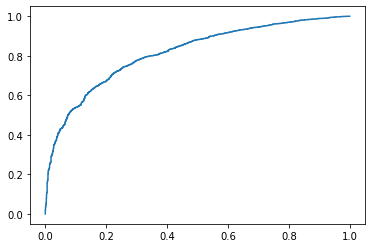

In [ ]:
display("Area under curve: " + str(metrics.auc(fpr, tpr)), plt.plot(fpr,tpr))

In [ ]:
LRM.fit(X, array_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=50, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# show the intercept of the trained model (Theta_0)
LRM.intercept_

array([-1.84498621])

In [ ]:
# show the coefficients of independent attributes
coeff_df = pd.DataFrame(LRM.coef_.flatten(), X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
tenure,-0.010570
MonthlyCharges_minmax,1.060228
SeniorCitizen,-0.578496
gender_Female,0.010135
Partner_No,0.039347
MultipleLines_No,-0.604212
MultipleLines_No phone service,-0.330137
Contract_Month-to-month,3.160049
Contract_One year,0.967990
PaperlessBilling_No,-0.629632


In [ ]:
print('Area Under Curve:', "%.4f" % metrics.auc(fpr, tpr))
print('Cross Validation Score:', "%.4f" % score_cv.mean())
for j in range(4, 7):
    print('Confusion Matrix', 'with thresold', float(j)/float(10), ':', '\n',
          confusion_matrix(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))
    print(classification_report(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))

Area Under Curve: 0.8156
Cross Validation Score: 0.7824
Confusion Matrix with thresold 0.4 : 
 [[4011  138]
 [1166  319]]
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      4149
           1       0.70      0.21      0.33      1485

    accuracy                           0.77      5634
   macro avg       0.74      0.59      0.59      5634
weighted avg       0.75      0.77      0.72      5634

Confusion Matrix with thresold 0.5 : 
 [[3726  423]
 [ 803  682]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4149
           1       0.62      0.46      0.53      1485

    accuracy                           0.78      5634
   macro avg       0.72      0.68      0.69      5634
weighted avg       0.77      0.78      0.77      5634

Confusion Matrix with thresold 0.6 : 
 [[3405  744]
 [ 589  896]]
              precision    recall  f1-score   support

           0       0.85      0.82    

## Predict testing data

In [ ]:
pred_val_test = LRM.predict(X_test)

In [ ]:
print("Accuracy from testing data: ", accuracy_score(y_test, pred_val_test, normalize = True, sample_weight = None))
print(confusion_matrix(y_test, pred_val_test))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y_test, pred_val_test))

Accuracy from testing data:  0.7814052519517388
[[909 116]
 [192 192]]
Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1025
           1       0.62      0.50      0.55       384

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.71      1409
weighted avg       0.77      0.78      0.77      1409



# Logistic Regression (on dropped columns)-L2-regularization



In [ ]:
#split the data
Xdropped = Xdropped.sort_values(['customerID'])
ydropped = ydropped.sort_values(['customerID'])

X, X_test, y, y_test = train_test_split(Xdropped, ydropped, test_size=0.2, random_state = 10)


In [ ]:
# define the model
LRM = LogisticRegression(penalty='l2', C=1,random_state=50, solver='newton-cg')
# change y column to datatype array
array_y = y.values.ravel()
# define cross val score
score_cv = cross_val_score(LRM, X, array_y, cv=10)

In [ ]:
#predict value of target based on cross validation
predict_y = cross_val_predict(LRM, X, array_y, cv=10)

In [ ]:
# Confusion matrix
print(confusion_matrix(array_y, predict_y))

[[3759  390]
 [ 768  717]]


In [ ]:
print(classification_report(array_y, predict_y))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4149
           1       0.65      0.48      0.55      1485

    accuracy                           0.79      5634
   macro avg       0.74      0.69      0.71      5634
weighted avg       0.78      0.79      0.78      5634



In [ ]:
# probablities for each prediction
proba_y = cross_val_predict(LRM, X, array_y, cv=10, method='predict_proba')
proba_y

array([[0.92414102, 0.07585898],
       [0.95034484, 0.04965516],
       [0.96748083, 0.03251917],
       ...,
       [0.72077068, 0.27922932],
       [0.5863754 , 0.4136246 ],
       [0.65948345, 0.34051655]])

In [ ]:
# Get the probabilities of being '0' for all instances at default threshold of 0.5
proba_y_0 = proba_y[:,0]

In [ ]:
# Set threshold for '0' to be 0.7
proba_y_0_thresold7= [0 if i >= 0.7 else 1 for i in proba_y_0]

In [ ]:
print("Confusion Matrix:", '\n',confusion_matrix(y, proba_y_0_thresold7))

Confusion Matrix: 
 [[3235  914]
 [ 419 1066]]


In [ ]:
print("Accuracy:",accuracy_score(y, proba_y_0_thresold7, normalize=True, sample_weight=None))

Accuracy: 0.763400780972666


In [ ]:
# calculate tpr and fpr based on different thresholds
fpr, tpr, thresholds = metrics.roc_curve(array_y,proba_y_0,pos_label=0)

'Area under curve: 0.8275626839618162'

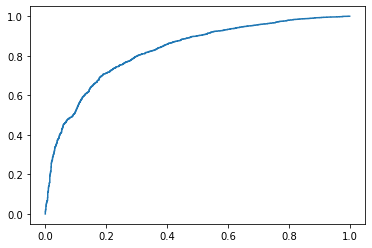

In [ ]:
display("Area under curve: " + str(metrics.auc(fpr, tpr)), plt.plot(fpr,tpr))

In [ ]:
LRM.fit(X, array_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=50, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# show the intercept of the trained model (Theta_0)
LRM.intercept_

array([-0.90052021])

In [ ]:
# show the coefficients of independent attributes
coeff_df = pd.DataFrame(LRM.coef_.flatten(), X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
TotalCharges_minmax,-3.428656
StreamingMovies_No,-0.310345
StreamingMovies_No internet service,-0.255447
StreamingTV_No,-0.348358
StreamingTV_No internet service,-0.255447
TechSupport_No,0.442465
TechSupport_No internet service,-0.255447
OnlineSecurity_No,0.522901
OnlineSecurity_No internet service,-0.255447
OnlineBackup_No,0.127511


In [ ]:
print('Area Under Curve:', "%.4f" % metrics.auc(fpr, tpr))
print('Cross Validation Score:', "%.4f" % score_cv.mean())
for j in range(4, 7):
    print('Confusion Matrix', 'with thresold', float(j)/float(10), ':', '\n',
          confusion_matrix(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))
    print(classification_report(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))

Area Under Curve: 0.8276
Cross Validation Score: 0.7945
Confusion Matrix with thresold 0.4 : 
 [[3922  227]
 [ 951  534]]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      4149
           1       0.70      0.36      0.48      1485

    accuracy                           0.79      5634
   macro avg       0.75      0.65      0.67      5634
weighted avg       0.78      0.79      0.77      5634

Confusion Matrix with thresold 0.5 : 
 [[3759  390]
 [ 768  717]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4149
           1       0.65      0.48      0.55      1485

    accuracy                           0.79      5634
   macro avg       0.74      0.69      0.71      5634
weighted avg       0.78      0.79      0.78      5634

Confusion Matrix with thresold 0.6 : 
 [[3555  594]
 [ 591  894]]
              precision    recall  f1-score   support

           0       0.86      0.86    

## Predict testing data

In [ ]:
pred_val_test = LRM.predict(X_test)

In [ ]:
print("Accuracy from testing data: ", accuracy_score(y_test, pred_val_test, normalize = True, sample_weight = None))
print(confusion_matrix(y_test, pred_val_test))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y_test, pred_val_test))

Accuracy from testing data:  0.7885024840312278
[[927  98]
 [200 184]]
Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1025
           1       0.65      0.48      0.55       384

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



# Logistic Regression (without dropping any columns) - L2-regularization

In [ ]:
#split the data
XnoDrop = XnoDrop.sort_values(['customerID'])
ynoDrop = ynoDrop.sort_values(['customerID'])

X, X_test, y, y_test = train_test_split(XnoDrop, ynoDrop, test_size=0.2, random_state = 10)


In [ ]:
# define the model
LRM = LogisticRegression(penalty='l2', C=1,random_state=50, solver='newton-cg')
# change y column to datatype array
array_y = y.values.ravel()
# define cross val score
score_cv = cross_val_score(LRM, X, array_y, cv=10)

In [ ]:
#predict value of target based on cross validation
predict_y = cross_val_predict(LRM, X, array_y, cv=10)

In [ ]:
# Confusion matrix
print(confusion_matrix(array_y, predict_y))

[[3718  431]
 [ 673  812]]


In [ ]:
print(classification_report(array_y, predict_y))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4149
           1       0.65      0.55      0.60      1485

    accuracy                           0.80      5634
   macro avg       0.75      0.72      0.73      5634
weighted avg       0.80      0.80      0.80      5634



In [ ]:
# probablities for each prediction
proba_y = cross_val_predict(LRM, X, array_y, cv=10, method='predict_proba')
proba_y

array([[0.84065919, 0.15934081],
       [0.95890448, 0.04109552],
       [0.95291215, 0.04708785],
       ...,
       [0.88440107, 0.11559893],
       [0.46655856, 0.53344144],
       [0.64927157, 0.35072843]])

In [ ]:
# Get the probabilities of being '0' for all instances at default threshold of 0.5
proba_y_0 = proba_y[:,0]

In [ ]:
# Set threshold for '0' to be 0.7
proba_y_0_thresold7= [0 if i >= 0.7 else 1 for i in proba_y_0]

In [ ]:
print("Confusion Matrix:", '\n',confusion_matrix(y, proba_y_0_thresold7))

Confusion Matrix: 
 [[3188  961]
 [ 353 1132]]


In [ ]:
print("Accuracy:",accuracy_score(y, proba_y_0_thresold7, normalize=True, sample_weight=None))

Accuracy: 0.7667731629392971


In [ ]:
# calculate tpr and fpr based on different thresholds
fpr, tpr, thresholds = metrics.roc_curve(array_y,proba_y_0,pos_label=0)

'Area under curve: 0.8450960151851934'

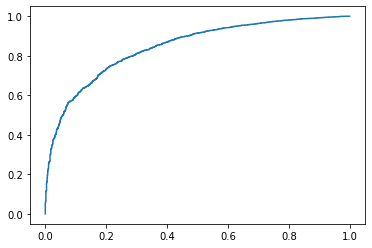

In [ ]:
display("Area under curve: " + str(metrics.auc(fpr, tpr)), plt.plot(fpr,tpr))

In [ ]:
LRM.fit(X, array_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=50, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# show the intercept of the trained model (Theta_0)
LRM.intercept_

array([-1.4849583])

In [ ]:
# show the coefficients of independent attributes
coeff_df = pd.DataFrame(LRM.coef_.flatten(), X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
tenure,-0.050316
MonthlyCharges_minmax,-0.004742
TotalCharges_minmax,1.751466
SeniorCitizen,-0.220050
gender_Female,-0.002405
Partner_No,0.036871
MultipleLines_No,-0.269336
MultipleLines_No phone service,0.197512
Contract_Month-to-month,1.371820
Contract_One year,0.749280


In [ ]:
print('Area Under Curve:', "%.4f" % metrics.auc(fpr, tpr))
print('Cross Validation Score:', "%.4f" % score_cv.mean())
for j in range(4, 7):
    print('Confusion Matrix', 'with thresold', float(j)/float(10), ':', '\n',
          confusion_matrix(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))
    print(classification_report(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))

Area Under Curve: 0.8451
Cross Validation Score: 0.8040
Confusion Matrix with thresold 0.4 : 
 [[3921  228]
 [ 906  579]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      4149
           1       0.72      0.39      0.51      1485

    accuracy                           0.80      5634
   macro avg       0.76      0.67      0.69      5634
weighted avg       0.79      0.80      0.78      5634

Confusion Matrix with thresold 0.5 : 
 [[3718  431]
 [ 673  812]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4149
           1       0.65      0.55      0.60      1485

    accuracy                           0.80      5634
   macro avg       0.75      0.72      0.73      5634
weighted avg       0.80      0.80      0.80      5634

Confusion Matrix with thresold 0.6 : 
 [[3482  667]
 [ 517  968]]
              precision    recall  f1-score   support

           0       0.87      0.84    

## Predict testing data

In [ ]:
pred_val_test = LRM.predict(X_test)

In [ ]:
print("Accuracy from testing data: ", accuracy_score(y_test, pred_val_test, normalize = True, sample_weight = None))
print(confusion_matrix(y_test, pred_val_test))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y_test, pred_val_test))

Accuracy from testing data:  0.7977288857345636
[[913 112]
 [173 211]]
Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1025
           1       0.65      0.55      0.60       384

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



# Logistic Regression (on remained columns) - Without regularization


In [ ]:
#split the data
Xdrop = Xdrop.sort_values(['customerID'])
ydrop = ydrop.sort_values(['customerID'])

X, X_test, y, y_test = train_test_split(Xdrop, ydrop, test_size=0.2, random_state = 10)

In [ ]:
# define the model
LRM = LogisticRegression(penalty="none", C=1,random_state=50, solver='newton-cg')
# change y column to datatype array
array_y = y.values.ravel()
# define cross val score
score_cv = cross_val_score(LRM, X, array_y, cv=10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

In [ ]:
#predict value of target based on cross validation
predict_y = cross_val_predict(LRM, X, array_y, cv=10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

In [ ]:
# Confusion matrix
print(confusion_matrix(array_y, predict_y))

[[3725  424]
 [ 718  767]]


In [ ]:
print(classification_report(array_y, predict_y))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4149
           1       0.64      0.52      0.57      1485

    accuracy                           0.80      5634
   macro avg       0.74      0.71      0.72      5634
weighted avg       0.79      0.80      0.79      5634



In [ ]:
# probablities for each prediction
proba_y = cross_val_predict(LRM, X, array_y, cv=10, method='predict_proba')
proba_y

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", Convergenc

array([[0.80354568, 0.19645432],
       [0.92885066, 0.07114934],
       [0.9211059 , 0.0788941 ],
       ...,
       [0.95562377, 0.04437623],
       [0.5127549 , 0.4872451 ],
       [0.72176083, 0.27823917]])

In [ ]:
# Get the probabilities of being '0' for all instances at default threshold of 0.5
proba_y_0 = proba_y[:,0]

In [ ]:
# Set threshold for '0' to be 0.7
proba_y_0_thresold7= [0 if i >= 0.7 else 1 for i in proba_y_0]

In [ ]:
print("Confusion Matrix:", '\n',confusion_matrix(y, proba_y_0_thresold7))

Confusion Matrix: 
 [[3119 1030]
 [ 367 1118]]


In [ ]:
print("Accuracy:",accuracy_score(y, proba_y_0_thresold7, normalize=True, sample_weight=None))

Accuracy: 0.7520411785587504


In [ ]:
# calculate tpr and fpr based on different thresholds
fpr, tpr, thresholds = metrics.roc_curve(array_y,proba_y_0,pos_label=0)

'Area under curve: 0.8377247204916523'

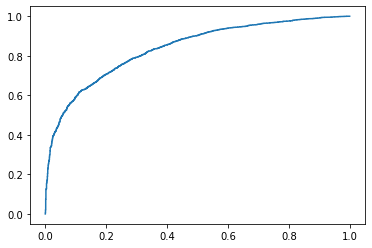

In [ ]:
display("Area under curve: " + str(metrics.auc(fpr, tpr)), plt.plot(fpr,tpr))

In [ ]:
LRM.fit(X, array_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=50, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# show the intercept of the trained model (Theta_0)
LRM.intercept_

array([-4.35405493])

In [ ]:
# show the coefficients of independent attributes
coeff_df = pd.DataFrame(LRM.coef_.flatten(), X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
tenure,0.002800
MonthlyCharges_minmax,155.500134
SeniorCitizen,-1.111977
gender_Female,-0.008156
Partner_No,0.066658
MultipleLines_No,0.330438
MultipleLines_No phone service,1.198961
Contract_Month-to-month,4.155597
Contract_One year,2.156550
PaperlessBilling_No,-0.320778


In [ ]:
print('Area Under Curve:', "%.4f" % metrics.auc(fpr, tpr))
print('Cross Validation Score:', "%.4f" % score_cv.mean())
for j in range(4, 7):
    print('Confusion Matrix', 'with thresold', float(j)/float(10), ':', '\n',
          confusion_matrix(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))
    print(classification_report(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))

Area Under Curve: 0.8377
Cross Validation Score: 0.7973
Confusion Matrix with thresold 0.4 : 
 [[3932  217]
 [ 961  524]]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      4149
           1       0.71      0.35      0.47      1485

    accuracy                           0.79      5634
   macro avg       0.76      0.65      0.67      5634
weighted avg       0.78      0.79      0.76      5634

Confusion Matrix with thresold 0.5 : 
 [[3725  424]
 [ 718  767]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4149
           1       0.64      0.52      0.57      1485

    accuracy                           0.80      5634
   macro avg       0.74      0.71      0.72      5634
weighted avg       0.79      0.80      0.79      5634

Confusion Matrix with thresold 0.6 : 
 [[3421  728]
 [ 511  974]]
              precision    recall  f1-score   support

           0       0.87      0.82    

## Predict testing data

In [ ]:
pred_val_test = LRM.predict(X_test)

In [ ]:
print("Accuracy from testing data: ", accuracy_score(y_test, pred_val_test, normalize = True, sample_weight = None))
print(confusion_matrix(y_test, pred_val_test))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y_test, pred_val_test))

Accuracy from testing data:  0.7934705464868701
[[914 111]
 [180 204]]
Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1025
           1       0.65      0.53      0.58       384

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



# Logistic Regression (on dropped columns) - Without regularization

In [ ]:
#split the data
Xdropped = Xdropped.sort_values(['customerID'])
ydropped = ydropped.sort_values(['customerID'])

X, X_test, y, y_test = train_test_split(Xdropped, ydropped, test_size=0.2, random_state = 10)

In [ ]:
# define the model
LRM = LogisticRegression(penalty='none', C=1,random_state=50, solver='newton-cg')
# change y column to datatype array
array_y = y.values.ravel()
# define cross val score
score_cv = cross_val_score(LRM, X, array_y, cv=10)

In [ ]:
#predict value of target based on cross validation
predict_y = cross_val_predict(LRM, X, array_y, cv=10)

In [ ]:
# Confusion matrix
print(confusion_matrix(array_y, predict_y))

[[3755  394]
 [ 764  721]]


In [ ]:
print(classification_report(array_y, predict_y))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4149
           1       0.65      0.49      0.55      1485

    accuracy                           0.79      5634
   macro avg       0.74      0.70      0.71      5634
weighted avg       0.78      0.79      0.78      5634



In [ ]:
# probablities for each prediction
proba_y = cross_val_predict(LRM, X, array_y, cv=10, method='predict_proba')
proba_y

array([[0.92396986, 0.07603014],
       [0.95165359, 0.04834641],
       [0.96936812, 0.03063188],
       ...,
       [0.73091442, 0.26908558],
       [0.58838021, 0.41161979],
       [0.66335192, 0.33664808]])

In [ ]:
# Get the probabilities of being '0' for all instances at default threshold of 0.5
proba_y_0 = proba_y[:,0]

In [ ]:
# Set threshold for '0' to be 0.7
proba_y_0_thresold7= [0 if i >= 0.7 else 1 for i in proba_y_0]

In [ ]:
print("Confusion Matrix:", '\n',confusion_matrix(y, proba_y_0_thresold7))

Confusion Matrix: 
 [[3248  901]
 [ 420 1065]]


In [ ]:
print("Accuracy:",accuracy_score(y, proba_y_0_thresold7, normalize=True, sample_weight=None))

Accuracy: 0.7655307064252751


In [ ]:
# calculate tpr and fpr based on different thresholds
fpr, tpr, thresholds = metrics.roc_curve(array_y,proba_y_0,pos_label=0)

'Area under curve: 0.8275870296116139'

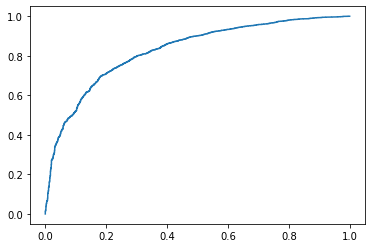

In [ ]:
display("Area under curve: " + str(metrics.auc(fpr, tpr)), plt.plot(fpr,tpr))

In [ ]:
LRM.fit(X, array_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=50, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# show the intercept of the trained model (Theta_0)
LRM.intercept_

array([-0.55413723])

In [ ]:
# show the coefficients of independent attributes
coeff_df = pd.DataFrame(LRM.coef_.flatten(), X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
TotalCharges_minmax,-3.610480
StreamingMovies_No,-0.328195
StreamingMovies_No internet service,-0.312232
StreamingTV_No,-0.365632
StreamingTV_No internet service,-0.312232
TechSupport_No,0.432741
TechSupport_No internet service,-0.312232
OnlineSecurity_No,0.509603
OnlineSecurity_No internet service,-0.312232
OnlineBackup_No,0.106153


In [ ]:
print('Area Under Curve:', "%.4f" % metrics.auc(fpr, tpr))
print('Cross Validation Score:', "%.4f" % score_cv.mean())
for j in range(4, 7):
    print('Confusion Matrix', 'with thresold', float(j)/float(10), ':', '\n',
          confusion_matrix(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))
    print(classification_report(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))

Area Under Curve: 0.8276
Cross Validation Score: 0.7945
Confusion Matrix with thresold 0.4 : 
 [[3916  233]
 [ 947  538]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4149
           1       0.70      0.36      0.48      1485

    accuracy                           0.79      5634
   macro avg       0.75      0.65      0.67      5634
weighted avg       0.78      0.79      0.77      5634

Confusion Matrix with thresold 0.5 : 
 [[3755  394]
 [ 764  721]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4149
           1       0.65      0.49      0.55      1485

    accuracy                           0.79      5634
   macro avg       0.74      0.70      0.71      5634
weighted avg       0.78      0.79      0.78      5634

Confusion Matrix with thresold 0.6 : 
 [[3553  596]
 [ 588  897]]
              precision    recall  f1-score   support

           0       0.86      0.86    

## Predict testing data

In [ ]:
pred_val_test = LRM.predict(X_test)

In [ ]:
print("Accuracy from testing data: ", accuracy_score(y_test, pred_val_test, normalize = True, sample_weight = None))
print(confusion_matrix(y_test, pred_val_test))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y_test, pred_val_test))

Accuracy from testing data:  0.7885024840312278
[[927  98]
 [200 184]]
Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1025
           1       0.65      0.48      0.55       384

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



# Logistic Regression (without dropping any columns)-Without regularization

In [ ]:
#split the data
XnoDrop = XnoDrop.sort_values(['customerID'])
ynoDrop = ynoDrop.sort_values(['customerID'])

X, X_test, y, y_test = train_test_split(XnoDrop, ynoDrop, test_size=0.2, random_state = 10)

In [ ]:
# define the model
LRM = LogisticRegression(penalty='none', C=1,random_state=50, solver='newton-cg')
# change y column to datatype array
array_y = y.values.ravel()
# define cross val score
score_cv = cross_val_score(LRM, X, array_y, cv=10)

In [ ]:
#predict value of target based on cross validation
predict_y = cross_val_predict(LRM, X, array_y, cv=10)

In [ ]:
# Confusion matrix
print(confusion_matrix(array_y, predict_y))

[[3714  435]
 [ 670  815]]


In [ ]:
print(classification_report(array_y, predict_y))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4149
           1       0.65      0.55      0.60      1485

    accuracy                           0.80      5634
   macro avg       0.75      0.72      0.73      5634
weighted avg       0.80      0.80      0.80      5634



In [ ]:
# probablities for each prediction
proba_y = cross_val_predict(LRM, X, array_y, cv=10, method='predict_proba')
proba_y

array([[0.83435846, 0.16564154],
       [0.96427653, 0.03572347],
       [0.95439328, 0.04560672],
       ...,
       [0.88569537, 0.11430463],
       [0.45835355, 0.54164645],
       [0.63372416, 0.36627584]])

In [ ]:
# probablities for each prediction
proba_y = cross_val_predict(LRM, X, array_y, cv=10, method='predict_proba')
proba_y

array([[0.83435846, 0.16564154],
       [0.96427653, 0.03572347],
       [0.95439328, 0.04560672],
       ...,
       [0.88569537, 0.11430463],
       [0.45835355, 0.54164645],
       [0.63372416, 0.36627584]])

In [ ]:
# Set threshold for '0' to be 0.7
proba_y_0_thresold7= [0 if i >= 0.7 else 1 for i in proba_y_0]

In [ ]:
print("Confusion Matrix:", '\n',confusion_matrix(y, proba_y_0_thresold7))

Confusion Matrix: 
 [[3248  901]
 [ 420 1065]]


In [ ]:
print("Accuracy:",accuracy_score(y, proba_y_0_thresold7, normalize=True, sample_weight=None))

Accuracy: 0.7655307064252751


In [ ]:
# calculate tpr and fpr based on different thresholds
fpr, tpr, thresholds = metrics.roc_curve(array_y,proba_y_0,pos_label=0)

'Area under curve: 0.8275870296116139'

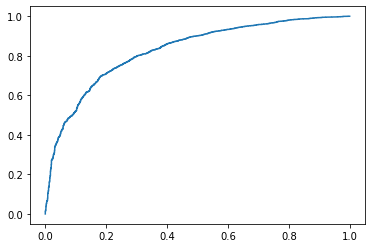

In [ ]:
display("Area under curve: " + str(metrics.auc(fpr, tpr)), plt.plot(fpr,tpr))

In [ ]:
LRM.fit(X, array_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=50, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# show the intercept of the trained model (Theta_0)
LRM.intercept_

array([2.71292292])

In [ ]:
# show the coefficients of independent attributes
coeff_df = pd.DataFrame(LRM.coef_.flatten(), X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
tenure,-0.058206
MonthlyCharges_minmax,-628.502871
TotalCharges_minmax,2.631330
SeniorCitizen,-0.221893
gender_Female,-0.006191
Partner_No,0.040182
MultipleLines_No,-0.614581
MultipleLines_No phone service,-0.675466
Contract_Month-to-month,1.468993
Contract_One year,0.844122


In [ ]:
print('Area Under Curve:', "%.4f" % metrics.auc(fpr, tpr))
print('Cross Validation Score:', "%.4f" % score_cv.mean())
for j in range(4, 7):
    print('Confusion Matrix', 'with thresold', float(j)/float(10), ':', '\n',
          confusion_matrix(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))
    print(classification_report(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))

Area Under Curve: 0.8276
Cross Validation Score: 0.8039
Confusion Matrix with thresold 0.4 : 
 [[3916  233]
 [ 947  538]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4149
           1       0.70      0.36      0.48      1485

    accuracy                           0.79      5634
   macro avg       0.75      0.65      0.67      5634
weighted avg       0.78      0.79      0.77      5634

Confusion Matrix with thresold 0.5 : 
 [[3755  394]
 [ 764  721]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4149
           1       0.65      0.49      0.55      1485

    accuracy                           0.79      5634
   macro avg       0.74      0.70      0.71      5634
weighted avg       0.78      0.79      0.78      5634

Confusion Matrix with thresold 0.6 : 
 [[3553  596]
 [ 588  897]]
              precision    recall  f1-score   support

           0       0.86      0.86    

## Predict testing data

In [ ]:
pred_val_test = LRM.predict(X_test)

In [ ]:
print("Accuracy from testing data: ", accuracy_score(y_test, pred_val_test, normalize = True, sample_weight = None))
print(confusion_matrix(y_test, pred_val_test))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y_test, pred_val_test))

Accuracy from testing data:  0.7977288857345636
[[910 115]
 [170 214]]
Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1025
           1       0.65      0.56      0.60       384

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



# Logistic Regression (L1-on remained columns)

In [ ]:
#split the data
Xdrop = Xdrop.sort_values(['customerID'])
ydrop = ydrop.sort_values(['customerID'])

X, X_test, y, y_test = train_test_split(Xdrop, ydrop, test_size=0.2, random_state = 10)


In [ ]:
Xdrop.head()

,tenure,MonthlyCharges_minmax,SeniorCitizen,gender_Female,Partner_No,MultipleLines_No,MultipleLines_No phone service,Contract_Month-to-month,Contract_One year,PaperlessBilling_No,MultipleLines_No_tenure,MultipleLines_No phone service_tenure,Contract_Month-to-month_tenure,Contract_One year_tenure,SeniorCitizen_0_MonthlyCharges_minmax,MultipleLines_No_MonthlyCharges_minmax,MultipleLines_No phone service_MonthlyCharges_minmax,Contract_Month-to-month_MonthlyCharges_minmax,Contract_One year_MonthlyCharges_minmax
customerID,,,,,,,,,,,,,,,,,,,
0002-ORFBO,9,0.005400,1,1,0,1,0,0,1,0,9,0,0,9,0.005400,0.005400,0.0,0.000000,0.0054
0003-MKNFE,9,0.004743,1,0,1,0,0,1,0,1,0,0,9,0,0.004743,0.000000,0.0,0.004743,0.0000
0004-TLHLJ,4,0.006358,1,0,1,1,0,1,0,0,4,0,4,0,0.006358,0.006358,0.0,0.006358,0.0000
0011-IGKFF,13,0.009139,0,0,0,1,0,1,0,0,13,0,13,0,0.000000,0.009139,0.0,0.009139,0.0000
0013-EXCHZ,3,0.007512,0,1,0,1,0,1,0,0,3,0,3,0,0.000000,0.007512,0.0,0.007512,0.0000


In [ ]:
# define the model
LRM = LogisticRegression(penalty='l1', C=1,random_state=50, solver='liblinear')
# change y column to datatype array
array_y = y.values.ravel()
# define cross val score
score_cv = cross_val_score(LRM, X, array_y, cv=10)

In [ ]:
#predict value of target based on cross validation
predict_y = cross_val_predict(LRM, X, array_y, cv=10)

In [ ]:
# Confusion matrix
print(confusion_matrix(array_y, predict_y))

[[3719  430]
 [ 804  681]]


In [ ]:
print(classification_report(array_y, predict_y))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4149
           1       0.61      0.46      0.52      1485

    accuracy                           0.78      5634
   macro avg       0.72      0.68      0.69      5634
weighted avg       0.77      0.78      0.77      5634



In [ ]:
# probablities for each prediction
proba_y = cross_val_predict(LRM, X, array_y, cv=10, method='predict_proba')
proba_y

array([[0.54616127, 0.45383873],
       [0.90525506, 0.09474494],
       [0.9321917 , 0.0678083 ],
       ...,
       [0.97694913, 0.02305087],
       [0.65015394, 0.34984606],
       [0.67923291, 0.32076709]])

In [ ]:
# Get the probabilities of being '0' for all instances at default threshold of 0.5
proba_y_0 = proba_y[:,0]

In [ ]:
# Set threshold for '0' to be 0.7
proba_y_0_thresold7= [0 if i >= 0.7 else 1 for i in proba_y_0]

In [ ]:
print("Confusion Matrix:", '\n',confusion_matrix(y, proba_y_0_thresold7))

Confusion Matrix: 
 [[2925 1224]
 [ 325 1160]]


In [ ]:
print("Accuracy:",accuracy_score(y, proba_y_0_thresold7, normalize=True, sample_weight=None))

Accuracy: 0.7250621228257011


In [ ]:
# calculate tpr and fpr based on different thresholds
fpr, tpr, thresholds = metrics.roc_curve(array_y,proba_y_0,pos_label=0)

'Area under curve: 0.8149742788209888'

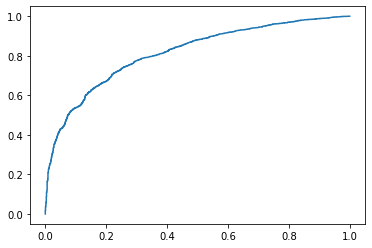

In [ ]:
display("Area under curve: " + str(metrics.auc(fpr, tpr)), plt.plot(fpr,tpr))

In [ ]:
LRM.fit(X, array_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=50, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# show the intercept of the trained model (Theta_0)
LRM.intercept_

array([-2.13014522])

In [ ]:
# show the coefficients of independent attributes
coeff_df = pd.DataFrame(LRM.coef_.flatten(), X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
tenure,-0.007646
MonthlyCharges_minmax,14.210322
SeniorCitizen,-0.564200
gender_Female,0.002021
Partner_No,0.028694
MultipleLines_No,-0.579941
MultipleLines_No phone service,-0.261513
Contract_Month-to-month,3.372030
Contract_One year,1.187078
PaperlessBilling_No,-0.611784


In [ ]:
print('Area Under Curve:', "%.4f" % metrics.auc(fpr, tpr))
print('Cross Validation Score:', "%.4f" % score_cv.mean())
for j in range(4, 7):
    print('Confusion Matrix', 'with thresold', float(j)/float(10), ':', '\n',
          confusion_matrix(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))
    print(classification_report(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))

Area Under Curve: 0.8150
Cross Validation Score: 0.7810
Confusion Matrix with thresold 0.4 : 
 [[4007  142]
 [1162  323]]
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      4149
           1       0.69      0.22      0.33      1485

    accuracy                           0.77      5634
   macro avg       0.73      0.59      0.60      5634
weighted avg       0.75      0.77      0.72      5634

Confusion Matrix with thresold 0.5 : 
 [[3719  430]
 [ 804  681]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4149
           1       0.61      0.46      0.52      1485

    accuracy                           0.78      5634
   macro avg       0.72      0.68      0.69      5634
weighted avg       0.77      0.78      0.77      5634

Confusion Matrix with thresold 0.6 : 
 [[3403  746]
 [ 588  897]]
              precision    recall  f1-score   support

           0       0.85      0.82    

## Predict testing data

In [ ]:
pred_val_test = LRM.predict(X_test)

In [ ]:
print("Accuracy from testing data: ", accuracy_score(y_test, pred_val_test, normalize = True, sample_weight = None))
print(confusion_matrix(y_test, pred_val_test))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y_test, pred_val_test))

Accuracy from testing data:  0.7828246983676366
[[909 116]
 [190 194]]
Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1025
           1       0.63      0.51      0.56       384

    accuracy                           0.78      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



# Logistic Regression (on dropped columns) - L1 regularization

In [ ]:
#split the data
Xdropped = Xdropped.sort_values(['customerID'])
ydropped = ydropped.sort_values(['customerID'])

X, X_test, y, y_test = train_test_split(Xdropped, ydropped, test_size=0.2, random_state = 10)

In [ ]:
# define the model
LRM = LogisticRegression(penalty='l1', C=1,random_state=50, solver='liblinear')
# change y column to datatype array
array_y = y.values.ravel()
# define cross val score
score_cv = cross_val_score(LRM, X, array_y, cv=10)

In [ ]:
#predict value of target based on cross validation
predict_y = cross_val_predict(LRM, X, array_y, cv=10)

In [ ]:
# Confusion matrix
print(confusion_matrix(array_y, predict_y))

[[3757  392]
 [ 765  720]]


In [ ]:
print(classification_report(array_y, predict_y))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4149
           1       0.65      0.48      0.55      1485

    accuracy                           0.79      5634
   macro avg       0.74      0.70      0.71      5634
weighted avg       0.78      0.79      0.78      5634



In [ ]:
# probablities for each prediction
proba_y = cross_val_predict(LRM, X, array_y, cv=10, method='predict_proba')
proba_y

array([[0.92290157, 0.07709843],
       [0.94989795, 0.05010205],
       [0.96866489, 0.03133511],
       ...,
       [0.72986032, 0.27013968],
       [0.58949589, 0.41050411],
       [0.65869765, 0.34130235]])

In [ ]:
# Get the probabilities of being '0' for all instances at default threshold of 0.5
proba_y_0 = proba_y[:,0]

In [ ]:
# Set threshold for '0' to be 0.7
proba_y_0_thresold7= [0 if i >= 0.7 else 1 for i in proba_y_0]

In [ ]:
print("Confusion Matrix:", '\n',confusion_matrix(y, proba_y_0_thresold7))

Confusion Matrix: 
 [[3246  903]
 [ 418 1067]]


In [ ]:
print("Accuracy:",accuracy_score(y, proba_y_0_thresold7, normalize=True, sample_weight=None))

Accuracy: 0.7655307064252751


In [ ]:
# calculate tpr and fpr based on different thresholds
fpr, tpr, thresholds = metrics.roc_curve(array_y,proba_y_0,pos_label=0)

'Area under curve: 0.8275706368740835'

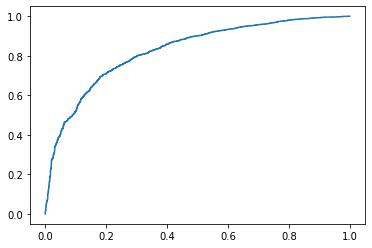

In [ ]:
display("Area under curve: " + str(metrics.auc(fpr, tpr)), plt.plot(fpr,tpr))

In [ ]:
LRM.fit(X, array_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=50, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# show the intercept of the trained model (Theta_0)
LRM.intercept_

array([-0.04973935])

In [ ]:
# show the coefficients of independent attributes
coeff_df = pd.DataFrame(LRM.coef_.flatten(), X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
TotalCharges_minmax,-3.572231
StreamingMovies_No,-0.318956
StreamingMovies_No internet service,-1.917797
StreamingTV_No,-0.356068
StreamingTV_No internet service,-0.291788
TechSupport_No,0.430336
TechSupport_No internet service,-0.047939
OnlineSecurity_No,0.508794
OnlineSecurity_No internet service,-0.010711
OnlineBackup_No,0.105267


In [ ]:
print('Area Under Curve:', "%.4f" % metrics.auc(fpr, tpr))
print('Cross Validation Score:', "%.4f" % score_cv.mean())
for j in range(4, 7):
    print('Confusion Matrix', 'with thresold', float(j)/float(10), ':', '\n',
          confusion_matrix(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))
    print(classification_report(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))

Area Under Curve: 0.8276
Cross Validation Score: 0.7946
Confusion Matrix with thresold 0.4 : 
 [[3917  232]
 [ 946  539]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4149
           1       0.70      0.36      0.48      1485

    accuracy                           0.79      5634
   macro avg       0.75      0.65      0.67      5634
weighted avg       0.78      0.79      0.77      5634

Confusion Matrix with thresold 0.5 : 
 [[3757  392]
 [ 765  720]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4149
           1       0.65      0.48      0.55      1485

    accuracy                           0.79      5634
   macro avg       0.74      0.70      0.71      5634
weighted avg       0.78      0.79      0.78      5634

Confusion Matrix with thresold 0.6 : 
 [[3557  592]
 [ 589  896]]
              precision    recall  f1-score   support

           0       0.86      0.86    

## Predict testing data

In [ ]:
pred_val_test = LRM.predict(X_test)

In [ ]:
print("Accuracy from testing data: ", accuracy_score(y_test, pred_val_test, normalize = True, sample_weight = None))
print(confusion_matrix(y_test, pred_val_test))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y_test, pred_val_test))

Accuracy from testing data:  0.7885024840312278
[[927  98]
 [200 184]]
Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1025
           1       0.65      0.48      0.55       384

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



# Logistic Regression (without dropping any columns)-L1 regularization

In [ ]:
#split the data
XnoDrop = XnoDrop.sort_values(['customerID'])
ynoDrop = ynoDrop.sort_values(['customerID'])

X, X_test, y, y_test = train_test_split(XnoDrop, ynoDrop, test_size=0.2, random_state = 10)

In [ ]:
# define the model
LRM = LogisticRegression(penalty='l1', C=1,random_state=50, solver='liblinear')
# change y column to datatype array
array_y = y.values.ravel()
# define cross val score
score_cv = cross_val_score(LRM, X, array_y, cv=10)

In [ ]:
#predict value of target based on cross validation
predict_y = cross_val_predict(LRM, X, array_y, cv=10)

In [ ]:
# Confusion matrix
print(confusion_matrix(array_y, predict_y))

[[3720  429]
 [ 675  810]]


In [ ]:
print(classification_report(array_y, predict_y))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4149
           1       0.65      0.55      0.59      1485

    accuracy                           0.80      5634
   macro avg       0.75      0.72      0.73      5634
weighted avg       0.80      0.80      0.80      5634



In [ ]:
# probablities for each prediction
proba_y = cross_val_predict(LRM, X, array_y, cv=10, method='predict_proba')
proba_y

array([[0.83579064, 0.16420936],
       [0.96024264, 0.03975736],
       [0.94746287, 0.05253713],
       ...,
       [0.88069291, 0.11930709],
       [0.46588319, 0.53411681],
       [0.6407846 , 0.3592154 ]])

In [ ]:
# probablities for each prediction
proba_y = cross_val_predict(LRM, X, array_y, cv=10, method='predict_proba')
proba_y

array([[0.83579064, 0.16420936],
       [0.96024264, 0.03975736],
       [0.94746287, 0.05253713],
       ...,
       [0.88069291, 0.11930709],
       [0.46588319, 0.53411681],
       [0.6407846 , 0.3592154 ]])

In [ ]:
# Set threshold for '0' to be 0.7
proba_y_0_thresold7= [0 if i >= 0.7 else 1 for i in proba_y_0]

In [ ]:
print("Confusion Matrix:", '\n',confusion_matrix(y, proba_y_0_thresold7))

Confusion Matrix: 
 [[3246  903]
 [ 418 1067]]


In [ ]:
print("Accuracy:",accuracy_score(y, proba_y_0_thresold7, normalize=True, sample_weight=None))

Accuracy: 0.7655307064252751


In [ ]:
# calculate tpr and fpr based on different thresholds
fpr, tpr, thresholds = metrics.roc_curve(array_y,proba_y_0,pos_label=0)

'Area under curve: 0.8275706368740835'

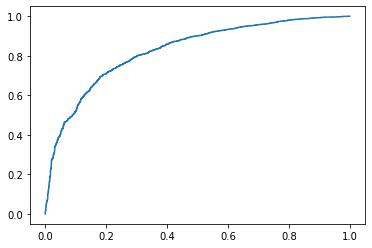

In [ ]:
display("Area under curve: " + str(metrics.auc(fpr, tpr)), plt.plot(fpr,tpr))

In [ ]:
LRM.fit(X, array_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=50, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# show the intercept of the trained model (Theta_0)
LRM.intercept_

array([-1.00358723])

In [ ]:
# show the coefficients of independent attributes
coeff_df = pd.DataFrame(LRM.coef_.flatten(), X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
tenure,-0.053390
MonthlyCharges_minmax,0.000000
TotalCharges_minmax,2.051120
SeniorCitizen,-0.226276
gender_Female,-0.000029
Partner_No,0.029184
MultipleLines_No,-0.271135
MultipleLines_No phone service,0.277461
Contract_Month-to-month,1.348919
Contract_One year,0.724199


In [ ]:
print('Area Under Curve:', "%.4f" % metrics.auc(fpr, tpr))
print('Cross Validation Score:', "%.4f" % score_cv.mean())
for j in range(4, 7):
    print('Confusion Matrix', 'with thresold', float(j)/float(10), ':', '\n',
          confusion_matrix(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))
    print(classification_report(y, [0 if i >= float(j)/float(10) else 1 for i in proba_y_0]))

Area Under Curve: 0.8276
Cross Validation Score: 0.8040
Confusion Matrix with thresold 0.4 : 
 [[3917  232]
 [ 946  539]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4149
           1       0.70      0.36      0.48      1485

    accuracy                           0.79      5634
   macro avg       0.75      0.65      0.67      5634
weighted avg       0.78      0.79      0.77      5634

Confusion Matrix with thresold 0.5 : 
 [[3757  392]
 [ 765  720]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4149
           1       0.65      0.48      0.55      1485

    accuracy                           0.79      5634
   macro avg       0.74      0.70      0.71      5634
weighted avg       0.78      0.79      0.78      5634

Confusion Matrix with thresold 0.6 : 
 [[3557  592]
 [ 589  896]]
              precision    recall  f1-score   support

           0       0.86      0.86    

## Predict testing data

In [ ]:
pred_val_test = LRM.predict(X_test)

In [ ]:
print("Accuracy from testing data: ", accuracy_score(y_test, pred_val_test, normalize = True, sample_weight = None))
print(confusion_matrix(y_test, pred_val_test))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y_test, pred_val_test))

Accuracy from testing data:  0.7955997161107168
[[910 115]
 [173 211]]
Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1025
           1       0.65      0.55      0.59       384

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



Among the models, the model including all variables with L2-regularization performs the best in cross
validation score, recall and AUC. It also gets the same score with the model dropping the variables in
precision. Therefore, we believe that the model including all variables with L2-regularization is the
best model to predict testing data. 

We find that models including all variables perform better than the others in general. It is believed that
models with more attributes acquire more predictive power. According to the MCA above, most of the
dropped variables are much closer to the churn. It explains that models with dropped variables have
strong predictive power, while the remaining variables have less predictive power, and therefore it
performs better than models with remaining variables in all aspects.

There is one finding very surprising. Models without regularization get higher scores in cross
validation score, recall and AUC in average. It has the same score with models including
L2-regularization in precision and accuracy. This result is disappointing. We expected models with
regularization should perform better than models without regularization as the purpose of
regularization is to avoid overfitting issues. Upon further investigation, we found that the complexity
of logistics regression is not high (compared to decision tree) and the data set is rather large, therefore
overfitting should not be a problem. L1-regularization can also shrink the less important feature’s
coefficient to 0. This should work well for feature selection in case we have a huge number of
features.

**Interaction effect**

Tenure has 0.002976 coefficient in the “Remaining variable” model, it’s close to 0. While the one with
L1 regularization has -0.007676 coefficient. The coefficient of all the interaction variables with tenure
for L1 regularization is 0 or near 0. The difference in the sign is due to the interactions effect. This
means that the longer the tenure is, the less likely customers are related to other variables as well.

The relationship of the interaction variable and tenure would be explained below: clients with a longer
tenure sign a longer contract (2 year). Those with multiple lines have a longer tenure. It means that
those with longer tenure are loyal customers as they would sign up for multiple lines services.
Therefore, we would like to explore whether those who stayed with Telco longer would also sign up
for other services.

For those who signed up for more Telco services except phone services have a longer tenure.
Furthermore, the dropped variables model has a higher prediction power than the remaining variable
model, and most of the dropped variables are columns on different services offered by Telco.
Therefore, whether customers pay for more services have an extremely high impact on churn.

Another way to interpret the result is that those who are more dependent on Telecom tend to stay with
the company longer as the cost of changing to another company is higher than those who have less
dependency on Telecom services.

**Confounding variable**
In the “Full model without regularization”, the coefficient for monthly charges is negative (-628),
indicating the more you charge, the less likely customers will churn. This result is not logical at all, as
it is expected that customers are price-sensitive and prefer a cheap plan.

Therefore, “Monthly Charges” is an example of confounding variables, which is caused by
multicollinearity. Such multicollinearity was proved by the “Remaining model”, which shows that a
higher monthly charges would lead to a higher churn rate, with a positive coefficient of 149.

The confusing coefficient from the full model of monthly charges is due to the fact that most
customers who sign up for more services have high correlation with monthly charges, the correlation
effect affects the full model coefficient. The implication of this is that Telco needs to strike a balance
between cost and services provided.